# Recommendations Systems
## Assignment 3:  Neural Collaborative Filtering

**By:**  
Group 16

<br><br>

**The goal of this assignment is to:**
- Understand the concept of recommendations based on implicit data which is very common in real life.
- Understand how DL components can be used to implement a collaborative filtering & hybrid approach recommenders.
- Understand pros&cons comparing to other recommender system approaches.
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a link to google colab.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ should be used. 
- You may use Torch/Keras/TF packeges.
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).

**LINKS:**
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>Dataset</a>
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>Repository</a>
- <a href='https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96'>Blog Post Review</a>
<br>

**Google <a href='https://colab.research.google.com/'>Colaboratory</a>**  
        
    This is a great academic tool for students. Instead of installing and running "everything" on your Laptop - which probably will take you a lot of time - you can use Google Colab.  
    Basically, you can use it for all your Python needs.  

**PyTorch <a href='https://pytorch.org/tutorials/beginner/basics/intro.html'>Tutorials</a>**   
    
    Just follow steps 0-7 and you will have the basics skills to understand, build, and run DL recommender models. 

**Keras Kaggle's <a href='https://www.kaggle.com/learn/intro-to-deep-learning'>intro-to-deep-learning</a>**  
    
    This will give you a quick idea of what DL is, and how to utilize it.  
    They're using TensorFlow, while in our MLDL program we're using PyTorch.  




**Grading:**

- Q1 - 20 points - Dataset Preparation
- Q2 - 50 points - Neural Collaborative Filtering
- Q3 - 30 points - Loss Function

`Total: 100`

<br><br><br>

**Prerequisites**

In [3]:
# %pip install torch torchvision --quiet

**Imports**

In [4]:
# basic
import os 
import sys
import math
import heapq
import argparse
from time import time
import multiprocessing

# general
import warnings
import numpy as np
import scipy as sp

# visual
import matplotlib
import matplotlib.pyplot as plt


# notebook
from IPython.display import display, HTML


# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

# colab
from google.colab import drive  

**Hide Warnings**

In [5]:
warnings.filterwarnings('ignore')
# print torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

**Disable Autoscrolling**

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

<br><br><br>
<br><br><br>
<br><br><br>

## Question 1: Dataset Preparation (Ingestion)

---


<br><br>

This implementation contains one file for training and two files for testing:   
- ml-1m.train.rating   
- ml-1m.test.rating  
- ml-1m.test.negative   

<br>
(feel free to use visual explanations)
<br>

a. **Explain** the role and structure of each file and how it was created from the original <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>MovieLens 1M rating dataset</a>.

- train rating file consists of positive instances. Each line in the file is of the following format: user_id item_id rating time_stamp .
- test rating file consists of positive instances (basically last sample for each user of interaction which isn't in train). Each line in the file is of the following format: user_id item_id rating time_stamp . One line per user.
- Negative sample file is file which each line corresponds to user id and test item(positive) and 99 items ids which were negatively sampled, format: (user_id,item_id) , negative sample1,negative sample2, ...

b. **Explain** how the training dataset is created.

- We iterate through each line of the train file.
- We find the number of items and users.
- We create a sparse matrix with NXM (users X items)
- We go through the file again and for each user item pair in the file line we check if there has been rating with a value greater than 0.
- If there has been a positive rating we add a binary indicator of implicit feedback (1).

c. **Explain** how the test dataset is created.

- test ratings list:
 is a list with tuples of user, a positively rated item(which isn't in the train set).
- negative sampling list:
Each line in negative file contains 99 negative samples(the id of the user matches the index of the line of test ratings file).

Then during the evaluation we will evaluate the 99 negative samples and the positive sample from the test list.

#### Data Preperations:

In [8]:
# urls
train_url = "https://github.com/hexiangnan/neural_collaborative_filtering/blob/master/Data/ml-1m.train.rating?raw=true"
test_url = "https://github.com/hexiangnan/neural_collaborative_filtering/blob/master/Data/ml-1m.test.rating?raw=true"
test_neg_url = "https://github.com/hexiangnan/neural_collaborative_filtering/blob/master/Data/ml-1m.test.negative?raw=true"


In [9]:
import requests

def get_num_users_and_items(data_lines):
    num_users = 0
    num_items = 0
    for line in data_lines:
        line_values = line.split("\t")
        user_id = int(line_values[0])
        item_id = int(line_values[1])
        num_users = max(num_users, user_id)
        num_items = max(num_items, item_id)

    return num_users, num_items

def generate_matrix(data_lines, num_users, num_items):
    matrix = torch.zeros((num_users + 1, num_items + 1))
    for line in data_lines:
        line_values = line.split("\t")
        user_id = int(line_values[0])
        item_id = int(line_values[1])
        rating = float(line_values[2])
        if rating > 0:
            matrix[user_id, item_id] = 1.0
    
    return matrix
    

def load_data_as_matrix(url):
    # download data with requests
    response = requests.get(url)
    # Read as a text file
    data = response.text
    # Split by lines
    data_lines = data.splitlines()
    # Get number of users and items
    num_users, num_items = get_num_users_and_items(data_lines)\
    # Construct matrix
    mat = generate_matrix(data_lines, num_users, num_items)
    
    return mat

def load_negatives_vector(url):
    # download data with requests
    response = requests.get(url)
    # Read as a text file
    data = response.text
    # Split by lines
    data_lines = data.splitlines()
    # Construct vector
    vector = []
    for line in data_lines:
        line_values = line.split("\t")
        vector.append([int(x) for x in line_values[1:]])
    
    return vector

def load_data_as_list(url):
    res = []
    # download data with requests
    response = requests.get(url)
    # Read as a text file
    data = response.text
    # Split by lines
    data_lines = data.splitlines()
    
    for line in data_lines:
        line_values = line.split("\t")
        user_id = int(line_values[0])
        item_id = int(line_values[1])
        res.append((user_id, item_id))

    return res
     


In [10]:
train_matrix = load_data_as_matrix(train_url)
test_ratings = load_data_as_list(test_url)
test_neg_vector = load_negatives_vector(test_neg_url)

num_users, num_items = train_matrix.shape

In [11]:
# print shapes of train and test matrices
print("Train matrix shape: ", train_matrix.shape)
print("Test matrix shape: ", len(test_ratings))
print(test_ratings[0])
# print shape of test negative vector
print("Test negative vector shape: ", len(test_neg_vector))
print(len(test_neg_vector[0]))

Train matrix shape:  torch.Size([6040, 3706])
Test matrix shape:  6040
(0, 25)
Test negative vector shape:  6040
99


<br><br><br>
<br><br><br>
<br><br><br>

## Question 2: Neural Collaborative Filtering 
<br><br>

## a. Build the following four models using the neural collaborative filtering approach: 
- Matrix Factorization (MF)
- Multi layer perceptron (MLP)
- Generalized Matrix Factorization (GMF) 
- NeuroMatrixFactorization (NMF)

**For each model, use the best hyper-parameters suggested in the neuMF paper.**

<br><br><br><br>
#### Matrix Factorization (MF)  
<br>

In [12]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=32):
        super(MF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.emb_size = embedding_size
        self.emb_item = nn.Embedding(num_embeddings=num_items, embedding_dim=self.emb_size)
        self.emb_user = nn.Embedding(num_embeddings=num_users, embedding_dim=self.emb_size)
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.emb_user.weight, std=0.01)
        nn.init.normal_(self.emb_item.weight, std=0.01)

    def forward(self, users, items):
        emb_users = self.emb_user(users)
        emb_items = self.emb_item(items)
        element_wise_product = emb_users * emb_items
        res = element_wise_product.sum(dim=1)
        return res 

In [13]:
model_MF = MF(num_users, num_items, embedding_size=32)

Model's architecture:

In [14]:
# display/print the model architecture
print(model_MF)

MF(
  (emb_item): Embedding(3706, 32)
  (emb_user): Embedding(6040, 32)
)


<br><br><br><br><br><br>
#### Multi Layer Perceptron (MLP)

In [15]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=16, mlp_layers_sizes=[32, 16, 8], dropout=0.1, ll_activation= "Sigmoid",):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.mlp_layers_sizes = mlp_layers_sizes
        self.dropout = dropout
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_size)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_size)
        self.mlp_layers = nn.Sequential(
            nn.Linear(2 * embedding_size, mlp_layers_sizes[0]),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(mlp_layers_sizes[0], mlp_layers_sizes[1]),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(mlp_layers_sizes[1], mlp_layers_sizes[2]),
        )
        self.last_hidden = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(mlp_layers_sizes[2], 1)
        )
        self.activation= nn.Sigmoid() if ll_activation== "Sigmoid" else nn.ReLU() # last layer activation function
        
    def forward(self, user_ids, item_ids):
        user_embedding = self.user_embedding(user_ids)
        item_embedding = self.item_embedding(item_ids)
        input_vector = torch.cat([user_embedding, item_embedding], dim=1)
        output = self.mlp_layers(input_vector)
        output = self.last_hidden(output)
        output = self.activation(output)
        return output

        

In [16]:
model_MLP = MLP(num_users, num_items, embedding_size=16, mlp_layers_sizes=[32, 16, 8], dropout=0.1, ll_activation="Sigmoid")

Model's architecture:

In [17]:
# display/print the model architecture
print(model_MLP)

MLP(
  (user_embedding): Embedding(6040, 16)
  (item_embedding): Embedding(3706, 16)
  (mlp_layers): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
  )
  (last_hidden): Sequential(
    (0): ReLU()
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
  (activation): Sigmoid()
)


<br><br><br><br><br><br>
####Generalized Matrix Factorization (GMF)

In [18]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=32, ll_activation= "Sigmoid"):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.emb_size = embedding_size
        self.emb_item = nn.Embedding(num_embeddings=num_items, embedding_dim=self.emb_size)
        self.emb_user = nn.Embedding(num_embeddings=num_users, embedding_dim=self.emb_size)
        self.hidden = torch.nn.Linear(self.emb_size, 1) 
        # self.activation = nn.Sigmoid()
        # self.ll_activation= ll_activation
        self._init_weights()
        self.activation= nn.Sigmoid() if ll_activation== "Sigmoid" else nn.ReLU() # last layer activation function

    def _init_weights(self):
        nn.init.normal_(self.emb_user.weight, std=0.01)
        nn.init.normal_(self.emb_item.weight, std=0.01)

    def forward(self, users, items):
        emb_user = self.emb_user(users)
        emb_item = self.emb_item(items)
        element_wise = emb_user * emb_item
        output = self.hidden(element_wise)
        output = self.activation(output)
        return output
        


In [19]:
model_GMF = GMF(num_users, num_items,embedding_size = 32, ll_activation= "Sigmoid")

Model's architecture:

In [20]:
# display/print the model architecture
print(model_GMF)

GMF(
  (emb_item): Embedding(3706, 32)
  (emb_user): Embedding(6040, 32)
  (hidden): Linear(in_features=32, out_features=1, bias=True)
  (activation): Sigmoid()
)


<br><br><br><br><br><br>
#### NeuroMatrixFactorization (NMF)


In [21]:
# Note for the simplicity of the implementation I've decided not to take mlp and gmf as backbones(like it was done in the paper)
class NCF(nn.Module):
    def __init__(
        self,
        num_users,
        num_items,
        embedding_size=32,
        mlp_embedding_size=16,
        mlp_layers_sizes=[32, 16, 8],
        dropout=0.1,
        ll_activation= "Sigmoid",
    ):
        super(NCF, self).__init__()
        self.mlp = MLP(
            num_users,
            num_items,
            embedding_size=mlp_embedding_size,
            mlp_layers_sizes=mlp_layers_sizes,
            dropout=dropout,
        )
        self.gmf = GMF(num_users, num_items, embedding_size=embedding_size)
        self.neu_mf = nn.Linear(mlp_layers_sizes[-1] + embedding_size, 1)
        self.activation = nn.Sigmoid() if ll_activation == "Sigmoid" else nn.ReLU()
        self.mute_last_layers()

    def mute_last_layers(self):
        self.mlp.activation = nn.Identity()
        self.gmf.activation = nn.Identity()
        self.gmf.hidden = nn.Identity()
        self.mlp.last_hidden = nn.Identity()

    def forward(self, users, items):
        mlp_output = self.mlp(users, items)
        gmf_output = self.gmf(users, items)
        output = torch.cat([mlp_output, gmf_output], dim=1)
        output = self.neu_mf(output)
        output = self.activation(output)
        return output


In [22]:
model_NMF = NCF(num_users, num_items)

*Model*'s architecture:

In [23]:
# display/print the model architecture
print(model_NMF)

NCF(
  (mlp): MLP(
    (user_embedding): Embedding(6040, 16)
    (item_embedding): Embedding(3706, 16)
    (mlp_layers): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=32, out_features=16, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=16, out_features=8, bias=True)
    )
    (last_hidden): Identity()
    (activation): Identity()
  )
  (gmf): GMF(
    (emb_item): Embedding(3706, 32)
    (emb_user): Embedding(6040, 32)
    (hidden): Identity()
    (activation): Identity()
  )
  (neu_mf): Linear(in_features=40, out_features=1, bias=True)
  (activation): Sigmoid()
)


<br><br><br><br><br><br>

## b. Train and evaluate the recommendations accuracy of the models: 
- MF
- GMF
- MLP
- NMF

Compare the `LogLoss` and recommendations accuracy using `NDCG` and `MRR` metrics with cutoff values of 5 and 10.   
Discuss the comparison. 

**Metrics:**
- HitRatio
- nDCG
- MRR

In [24]:
# Use your own metrics implementation OR use external packages for the metrics.
# If you are using external packages make sure they work properly. 
# A lot of the packages available does not work as you would expect.

In [25]:
torch.cuda.is_available()
# Select torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Selected device: {device}")


Selected device: cuda:0


In [26]:
from typing import List

def compute_hit_rate_for_user(user_pred: torch.Tensor,  user_pred_item_ids: torch.Tensor, gt_item_id: int, top_n=10) -> int:
    top_n_indices = torch.argsort(user_pred, descending=True)[:top_n]
    # Get ids of the top n items
    top_n_item_ids = user_pred_item_ids[top_n_indices]
    # Check if the top n indices contains the index of the test item
    return 1 if gt_item_id in top_n_item_ids else 0
    

In [27]:
def compute_ndcg_for_user(
    user_pred: torch.Tensor, user_pred_item_ids: torch.Tensor, gt_item_id: int, top_n=5
) -> float:
    """Computes NDCG for a single user.
    Args:
        user_pred: list of predicted ratings for a single user
        user_pred_item_ids: list of item ids of the predicted ratings for a single user
        gt_item_id id of the ground truth item
        top_n: number of top items to consider
    Returns:
        NDCG for a single user
    """
    # Get the indices of the top_n items in user pred ratings
    top_n_indices = torch.argsort(user_pred, descending=True)[:top_n]
    # Get the indices of the top_n items in user pred item ids
    top_n_item_ids = user_pred_item_ids[top_n_indices]

    for i in range(top_n):
        if top_n_item_ids[i] == gt_item_id:
            # We know that idcg is 1 for this case we we can just return the dcg
            return 1 / np.log2(i + 2)
    return 0


In [28]:
def compute_mrr_for_user(user_pred: torch.Tensor, user_pred_item_ids: torch.Tensor, gt_item_id: int, top_n=5) -> float:
        """ Computes MRR for a single user.
        Args:
            user_pred: list of predicted ratings for a single user
            gt_item_index: index of the ground truth item
            top_n: number of top items to consider
        Returns:
            MRR for a single user
        """
        top_n_indices = torch.argsort(user_pred, descending=True)[:top_n]
        # Get the indices of the top_n items in user pred item ids
        top_n_item_ids = user_pred_item_ids[top_n_indices]

        for i in range(top_n):
            if top_n_item_ids[i] == gt_item_id:
                return 1 / (i + 1)
        # if there is no match, return 0
        return 0

**Evaluation:**

In [29]:
from typing import List, Tuple

def eval_rating_from_test(model, test_index: int, test_ratings: List[Tuple[int, int]], test_negatives: List[List[int]], top_n: int) -> Tuple[float, float, float]:
    user_id, gt_item_id = test_ratings[test_index]
    negative_samples = test_negatives[test_index]
    test_items_for_user = [gt_item_id] + negative_samples
    # Convert list to torch tensor
    test_items_for_user_as_tensor = torch.tensor(test_items_for_user).to(device)
    # This is a hack to get the user id as a tensor
    users = torch.full((test_items_for_user_as_tensor.shape[0], 1), user_id)
    users = users.flatten().to(device)
    predictions = model(users, test_items_for_user_as_tensor)
    # Squeeze the tensor to remove the extra dimension
    predictions = predictions.squeeze()
    # # Convert predictions to numpy array
    # predictions_as_numpy_array = predictions.detach().cpu().numpy()

    ndcg_score = compute_ndcg_for_user(predictions, test_items_for_user_as_tensor, gt_item_id, top_n)
    hit_rate_score = compute_hit_rate_for_user(predictions, test_items_for_user_as_tensor, gt_item_id, top_n)
    mrr_score = compute_mrr_for_user(predictions, test_items_for_user_as_tensor, gt_item_id, top_n)

    return ndcg_score, hit_rate_score, mrr_score

<br><br>
Create train data:

In [30]:
import torch
from torch.utils.data import Dataset
import numpy as np

# Has equal number of positive and negative samples
class MovieLenseDataset(Dataset):
    def __init__(self, train_matrix):
        self.ratings = train_matrix
        self.positive_rows, self.positive_cols = self.ratings.nonzero(as_tuple=True)
        n_positive_samples = len(self.positive_rows)
        masked_ratings = self.mask_test_samples(test_ratings, test_neg_vector)
        negative_rows, negative_cols = (masked_ratings == 0).nonzero(as_tuple=True)
        negative_sample_indices = np.random.choice(len(negative_rows), n_positive_samples)
        self.negative_rows, self.negative_cols = negative_rows[negative_sample_indices], negative_cols[negative_sample_indices]
        self.rows = np.concatenate([self.positive_rows, self.negative_rows])
        self.cols = np.concatenate([self.positive_cols, self.negative_cols])
        self.training_indices = np.arange(len(self.rows))

    def __len__(self):
        return len(self.training_indices)

    def __getitem__(self, idx):
        return (self.rows[idx], self.cols[idx], self.ratings[self.rows[idx], self.cols[idx]])
    
    def mask_test_samples(self, test_ratings, test_neg_vector):
        """Creates a new ratings matrix where test samples are masked out as ones."""
        new_ratings = torch.clone(self.ratings)
        # There is a better way to do it in pytorch(without loops) - I know, this is just HW not production code
        for user_id, item_id in test_ratings:
            new_ratings[user_id, item_id] = 1
            new_ratings[user_id, test_neg_vector[user_id]] = 1
        return new_ratings


training_data = MovieLenseDataset(train_matrix)
train_size = int(0.9 * len(training_data))
val_size = len(training_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, val_size])



<br><br>
train & eval:
- Create a training function 
- Evaluate the models trained and save the results accordingly 

In [31]:
from tqdm import tqdm
import timeit

@torch.no_grad()
def validate(model, val_data_loader, criterion):
    val_loss = 0.0
    for batch in tqdm(val_data_loader):
        user_indices, item_indices, ratings = batch
        user_indices = user_indices.to(device)
        item_indices = item_indices.to(device)
        ratings = ratings.to(device)
        pred = model(user_indices, item_indices)
        # Squeeze pred
        pred = pred.squeeze()
        loss = criterion(pred, ratings)
        val_loss += loss.item()

    return val_loss / len(val_data_loader)


@torch.enable_grad()
def model_train(model, criterion, optimizer, scheduler, batch_size=64, num_epochs=10, ):
    # Start timer with timeit
    start = timeit.default_timer()
    train_loss_history = []
    val_loss_history = []
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    for epoch in tqdm(range(num_epochs)):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print("-" * 10)
        model.train()  # Set model to training mode
        running_loss = 0.0  # total loss of the network at each epoch
        # Iterate over data.
        for i, batch in tqdm(enumerate(train_data_loader, 0)):
            user_indices, item_indices, ratings = batch
            # Convert outputs to device
            user_indices = user_indices.to(device)
            item_indices = item_indices.to(device)
            ratings = ratings.to(device)
            optimizer.zero_grad()

            pred = model(user_indices, item_indices)
            # Squeeze pred
            pred = pred.squeeze()
            loss = criterion(pred, ratings)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if scheduler is not None:
                scheduler.step()

        epoch_loss = running_loss / len(train_data_loader)
        print("Epoch Loss: {:.4f}".format(epoch_loss))

        # save the metrics
        train_loss_history.append(epoch_loss)

        # Validation
        val_loss = validate(model, val_data_loader, criterion)
        print("Epoch Val Loss: {:.4f}".format(val_loss))
        val_loss_history.append(val_loss)
        # Check for early stopping
        if early_stop(val_loss_history):
            print("Early stopping")
            break
    
    # Stop timer with timeit
    stop = timeit.default_timer()
    train_time = stop - start

    return model, train_loss_history, val_loss_history, train_time 

def early_stop(val_loss_history, patience=5):
    if len(val_loss_history) < patience:
        return False
    else:
        return val_loss_history[-1] > min(val_loss_history[-(patience + 1) : -1])


In [32]:
# create eval loop
@torch.no_grad()
def model_eval(model, test_ratings: List[int], test_negatives: List[int], top_n: int):
    model.eval()
    ndcg_scores = []
    hit_rate_scores = []
    mrr_scores = []

    # Iterate over data.
    for i in tqdm(range(len(test_negatives))):
          ndcg_score, hit_rate_score, mrr_score = eval_rating_from_test(model, i, test_ratings, test_negatives, top_n)
          ndcg_scores.append(ndcg_score)
          hit_rate_scores.append(hit_rate_score)
          mrr_scores.append(mrr_score)
    
    mean_mrr = np.mean(mrr_scores)
    mean_ndcg = np.mean(ndcg_scores)
    mean_hit_rate = np.mean(hit_rate_scores)

    return mean_mrr, mean_ndcg, mean_hit_rate

**HyperParams:**

In [33]:
from torch.optim import lr_scheduler

num_epoch= 10
models = {
    "MF": MF(num_users, num_items, embedding_size=32),
    "MLP": MLP(num_users, num_items, embedding_size=16, mlp_layers_sizes=[32, 16, 8], dropout=0.1),
    "GMF": GMF(num_users, num_items,embedding_size = 32),
    "NMF": NCF(num_users, num_items),
}

lr_rates = {
    "MF": 0.001,
    "MLP": 0.001,
    "GMF": 0.001,
    "NMF": 0.001,
}

optimizers = {
    "MF": torch.optim.Adam(models["MF"].parameters(), lr=lr_rates["MF"]),
    "MLP": torch.optim.Adam(models["MLP"].parameters(), lr=lr_rates["MLP"]),
    "GMF": torch.optim.Adam(models["GMF"].parameters(), lr=lr_rates["GMF"]),
    "NMF": torch.optim.Adam(models["NMF"].parameters(), lr=lr_rates["NMF"]),
}

batch_sizes = {
    "MF": 256,
    "MLP": 256,
    "GMF": 256,
    "NMF": 256,
}
num_epochs = {
    "MF": num_epoch,
    "MLP": num_epoch,
    "GMF": num_epoch,
    "NMF": num_epoch,
}
# Cross Entropy Loss
criteria = {
    "NMF": nn.BCELoss(),
    "MF":  nn.BCEWithLogitsLoss(),
    "MLP": nn.BCELoss(),
    "GMF": nn.BCELoss(),
}



All Results:

In [34]:


# Convert all models to use device
for model_name, model in models.items():
    model.to(device)

loss_history_per_model = {
    "MF": {
        "train": [],
        "val": [],
    },
    "MLP": {
        "train": [],
        "val": [],
    },
    "GMF": {
        "train": [],
        "val": [],
    },
    "NMF": {
        "train": [],
        "val": [],
    }
}

train_times_per_model = {
    "MF": 0,
    "MLP": 0,
    "GMF": 0,
    "NMF": 0,
}

for model_name, model in models.items():
    print(f"Training {model_name}")
    model, train_loss_history, val_loss_history, train_time = model_train(model, criteria[model_name], optimizers[model_name], None, batch_size=batch_sizes[model_name], num_epochs=num_epochs[model_name],)
    loss_history_per_model[model_name]["train"] = train_loss_history
    loss_history_per_model[model_name]["val"] = val_loss_history
    train_times_per_model[model_name] = train_time



Training MF


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------



0it [00:00, ?it/s]
1it [00:00,  4.60it/s]
29it [00:00, 113.49it/s]
63it [00:00, 193.99it/s]
97it [00:00, 241.46it/s]
128it [00:00, 262.77it/s]
162it [00:00, 285.76it/s]
195it [00:00, 298.55it/s]
227it [00:00, 305.02it/s]
261it [00:01, 313.85it/s]
295it [00:01, 320.46it/s]
328it [00:01, 322.62it/s]
362it [00:01, 325.90it/s]
395it [00:01, 326.52it/s]
429it [00:01, 328.08it/s]
463it [00:01, 330.18it/s]
497it [00:01, 330.43it/s]
531it [00:01, 329.16it/s]
564it [00:01, 327.64it/s]
597it [00:02, 316.79it/s]
629it [00:02, 315.87it/s]
662it [00:02, 319.79it/s]
696it [00:02, 323.28it/s]
730it [00:02, 326.89it/s]
764it [00:02, 329.40it/s]
797it [00:02, 324.23it/s]
830it [00:02, 324.84it/s]
863it [00:02, 325.54it/s]
896it [00:02, 326.12it/s]
930it [00:03, 328.08it/s]
963it [00:03, 327.89it/s]
997it [00:03, 329.67it/s]
1030it [00:03, 327.74it/s]
1063it [00:03, 320.62it/s]
1097it [00:03, 325.41it/s]
1131it [00:03, 327.85it/s]
1164it [00:03, 327.36it/s]
1197it [00:03, 327.96it/s]
1230it [00:03, 327

Epoch Loss: 0.4744



 10%|█         | 1/10 [00:23<03:32, 23.67s/it]

Epoch Val Loss: 0.3790
Epoch 2/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.77it/s]
34it [00:00, 184.62it/s]
68it [00:00, 251.86it/s]
102it [00:00, 284.44it/s]
134it [00:00, 294.22it/s]
167it [00:00, 305.87it/s]
200it [00:00, 312.64it/s]
234it [00:00, 320.31it/s]
267it [00:00, 321.67it/s]
301it [00:01, 324.92it/s]
334it [00:01, 325.36it/s]
367it [00:01, 325.92it/s]
400it [00:01, 323.33it/s]
433it [00:01, 324.12it/s]
466it [00:01, 319.47it/s]
499it [00:01, 322.27it/s]
533it [00:01, 326.49it/s]
566it [00:01, 326.30it/s]
600it [00:01, 329.48it/s]
634it [00:02, 331.73it/s]
668it [00:02, 332.17it/s]
702it [00:02, 333.86it/s]
736it [00:02, 332.29it/s]
770it [00:02, 322.59it/s]
803it [00:02, 286.61it/s]
837it [00:02, 298.92it/s]
871it [00:02, 309.68it/s]
905it [00:02, 315.81it/s]
939it [00:03, 320.00it/s]
973it [00:03, 324.48it/s]
1006it [00:03, 326.05it/s]
1039it [00:03, 322.25it/s]
1073it [00:03, 325.25it/s]
1107it [00:03, 326.91it/s]
1140it [00:03, 326.95it/s]
1174it [00:03, 328.45it/s]
1208it [00:03, 331.22it/s]
1242it [00:03, 3

Epoch Loss: 0.3651



 20%|██        | 2/10 [00:47<03:08, 23.56s/it]

Epoch Val Loss: 0.3519
Epoch 3/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.69it/s]
34it [00:00, 183.64it/s]
67it [00:00, 245.60it/s]
101it [00:00, 279.41it/s]
135it [00:00, 298.85it/s]
168it [00:00, 309.03it/s]
200it [00:00, 312.43it/s]
233it [00:00, 316.70it/s]
267it [00:00, 322.48it/s]
301it [00:01, 326.55it/s]
334it [00:01, 326.78it/s]
367it [00:01, 317.53it/s]
400it [00:01, 320.89it/s]
433it [00:01, 321.59it/s]
466it [00:01, 323.14it/s]
499it [00:01, 323.58it/s]
532it [00:01, 323.69it/s]
566it [00:01, 326.14it/s]
600it [00:01, 329.29it/s]
634it [00:02, 330.87it/s]
668it [00:02, 327.77it/s]
702it [00:02, 329.82it/s]
735it [00:02, 328.59it/s]
769it [00:02, 330.04it/s]
803it [00:02, 324.18it/s]
836it [00:02, 325.46it/s]
870it [00:02, 329.08it/s]
904it [00:02, 332.26it/s]
938it [00:02, 332.24it/s]
972it [00:03, 333.86it/s]
1006it [00:03, 325.63it/s]
1040it [00:03, 327.45it/s]
1074it [00:03, 330.85it/s]
1109it [00:03, 333.82it/s]
1143it [00:03, 333.53it/s]
1177it [00:03, 333.38it/s]
1211it [00:03, 312.26it/s]
1244it [00:03, 3

Epoch Loss: 0.3313



 30%|███       | 3/10 [01:10<02:44, 23.53s/it]

Epoch Val Loss: 0.3248
Epoch 4/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.84it/s]
34it [00:00, 186.83it/s]
67it [00:00, 249.37it/s]
100it [00:00, 278.51it/s]
134it [00:00, 299.33it/s]
167it [00:00, 306.93it/s]
200it [00:00, 313.74it/s]
234it [00:00, 319.55it/s]
268it [00:00, 323.17it/s]
301it [00:01, 325.11it/s]
334it [00:01, 326.08it/s]
367it [00:01, 323.26it/s]
401it [00:01, 327.68it/s]
434it [00:01, 326.79it/s]
467it [00:01, 314.80it/s]
499it [00:01, 311.11it/s]
533it [00:01, 317.26it/s]
567it [00:01, 323.11it/s]
601it [00:01, 325.47it/s]
634it [00:02, 324.94it/s]
667it [00:02, 323.23it/s]
700it [00:02, 324.06it/s]
733it [00:02, 324.89it/s]
767it [00:02, 326.94it/s]
801it [00:02, 328.04it/s]
834it [00:02, 323.39it/s]
867it [00:02, 323.56it/s]
900it [00:02, 320.26it/s]
933it [00:02, 319.37it/s]
967it [00:03, 322.93it/s]
1001it [00:03, 325.96it/s]
1034it [00:03, 324.21it/s]
1068it [00:03, 327.55it/s]
1101it [00:03, 327.60it/s]
1134it [00:03, 327.95it/s]
1167it [00:03, 326.41it/s]
1201it [00:03, 328.72it/s]
1235it [00:03, 3

Epoch Loss: 0.3021



 40%|████      | 4/10 [01:34<02:21, 23.60s/it]

Epoch Val Loss: 0.3073
Epoch 5/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.89it/s]
35it [00:00, 192.32it/s]
69it [00:00, 255.98it/s]
102it [00:00, 282.21it/s]
136it [00:00, 301.59it/s]
170it [00:00, 312.61it/s]
204it [00:00, 320.83it/s]
238it [00:00, 324.59it/s]
271it [00:00, 325.14it/s]
305it [00:01, 326.90it/s]
339it [00:01, 329.64it/s]
373it [00:01, 330.28it/s]
407it [00:01, 327.92it/s]
440it [00:01, 325.63it/s]
473it [00:01, 325.50it/s]
506it [00:01, 323.35it/s]
540it [00:01, 325.81it/s]
573it [00:01, 326.55it/s]
606it [00:01, 326.26it/s]
640it [00:02, 328.21it/s]
673it [00:02, 328.25it/s]
706it [00:02, 326.83it/s]
740it [00:02, 329.43it/s]
773it [00:02, 328.47it/s]
806it [00:02, 328.25it/s]
840it [00:02, 330.58it/s]
874it [00:02, 331.46it/s]
908it [00:02, 332.92it/s]
942it [00:02, 330.76it/s]
976it [00:03, 330.03it/s]
1010it [00:03, 330.91it/s]
1044it [00:03, 330.99it/s]
1078it [00:03, 330.97it/s]
1112it [00:03, 324.56it/s]
1146it [00:03, 327.85it/s]
1179it [00:03, 328.37it/s]
1213it [00:03, 330.30it/s]
1247it [00:03, 3

Epoch Loss: 0.2806



 50%|█████     | 5/10 [01:57<01:57, 23.57s/it]

Epoch Val Loss: 0.2971
Epoch 6/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.85it/s]
34it [00:00, 185.17it/s]
65it [00:00, 236.78it/s]
97it [00:00, 264.22it/s]
131it [00:00, 288.07it/s]
165it [00:00, 303.93it/s]
199it [00:00, 313.70it/s]
231it [00:00, 314.40it/s]
265it [00:00, 320.37it/s]
298it [00:01, 323.18it/s]
331it [00:01, 324.93it/s]
365it [00:01, 327.74it/s]
398it [00:01, 317.19it/s]
432it [00:01, 321.65it/s]
465it [00:01, 323.46it/s]
499it [00:01, 326.11it/s]
532it [00:01, 326.49it/s]
566it [00:01, 327.95it/s]
599it [00:01, 327.11it/s]
632it [00:02, 327.46it/s]
666it [00:02, 328.67it/s]
699it [00:02, 325.74it/s]
733it [00:02, 327.63it/s]
767it [00:02, 329.26it/s]
800it [00:02, 329.35it/s]
834it [00:02, 330.40it/s]
868it [00:02, 331.45it/s]
902it [00:02, 330.13it/s]
936it [00:02, 332.40it/s]
970it [00:03, 333.70it/s]
1004it [00:03, 334.90it/s]
1038it [00:03, 336.16it/s]
1072it [00:03, 334.41it/s]
1106it [00:03, 335.47it/s]
1140it [00:03, 326.94it/s]
1173it [00:03, 321.84it/s]
1206it [00:03, 313.21it/s]
1240it [00:03, 31

Epoch Loss: 0.2624



 60%|██████    | 6/10 [02:21<01:34, 23.61s/it]

Epoch Val Loss: 0.2910
Epoch 7/10
----------



0it [00:00, ?it/s]
1it [00:00,  9.10it/s]
34it [00:00, 189.76it/s]
64it [00:00, 238.20it/s]
97it [00:00, 271.47it/s]
130it [00:00, 290.67it/s]
163it [00:00, 303.49it/s]
196it [00:00, 309.08it/s]
230it [00:00, 317.20it/s]
264it [00:00, 324.01it/s]
298it [00:01, 327.62it/s]
332it [00:01, 331.07it/s]
366it [00:01, 329.53it/s]
399it [00:01, 326.88it/s]
432it [00:01, 327.29it/s]
465it [00:01, 326.24it/s]
498it [00:01, 325.08it/s]
532it [00:01, 327.54it/s]
565it [00:01, 327.45it/s]
599it [00:01, 329.77it/s]
633it [00:02, 332.62it/s]
667it [00:02, 332.87it/s]
701it [00:02, 331.93it/s]
735it [00:02, 302.75it/s]
766it [00:02, 293.29it/s]
800it [00:02, 305.25it/s]
833it [00:02, 311.93it/s]
866it [00:02, 315.33it/s]
898it [00:02, 300.76it/s]
932it [00:03, 311.05it/s]
966it [00:03, 317.36it/s]
1000it [00:03, 322.47it/s]
1033it [00:03, 323.68it/s]
1066it [00:03, 325.00it/s]
1099it [00:03, 321.75it/s]
1132it [00:03, 323.86it/s]
1165it [00:03, 325.43it/s]
1199it [00:03, 327.09it/s]
1232it [00:03, 32

Epoch Loss: 0.2465



 70%|███████   | 7/10 [02:45<01:10, 23.64s/it]

Epoch Val Loss: 0.2884
Epoch 8/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.83it/s]
34it [00:00, 186.82it/s]
67it [00:00, 250.05it/s]
101it [00:00, 281.84it/s]
135it [00:00, 300.31it/s]
169it [00:00, 311.81it/s]
203it [00:00, 319.27it/s]
237it [00:00, 323.82it/s]
271it [00:00, 327.02it/s]
304it [00:01, 325.62it/s]
338it [00:01, 329.44it/s]
371it [00:01, 325.97it/s]
404it [00:01, 327.12it/s]
438it [00:01, 329.89it/s]
472it [00:01, 330.05it/s]
506it [00:01, 328.54it/s]
539it [00:01, 328.37it/s]
572it [00:01, 328.39it/s]
605it [00:01, 324.61it/s]
638it [00:02, 325.92it/s]
672it [00:02, 328.42it/s]
706it [00:02, 328.95it/s]
740it [00:02, 329.86it/s]
773it [00:02, 329.54it/s]
806it [00:02, 328.92it/s]
840it [00:02, 330.92it/s]
874it [00:02, 330.94it/s]
908it [00:02, 328.08it/s]
941it [00:02, 319.94it/s]
974it [00:03, 321.95it/s]
1008it [00:03, 324.90it/s]
1041it [00:03, 326.30it/s]
1075it [00:03, 328.47it/s]
1109it [00:03, 329.61it/s]
1142it [00:03, 329.69it/s]
1176it [00:03, 332.13it/s]
1210it [00:03, 330.62it/s]
1244it [00:03, 3

Epoch Loss: 0.2326



 70%|███████   | 7/10 [03:08<01:20, 26.98s/it]


Epoch Val Loss: 0.2888
Early stopping
Training MLP


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------



0it [00:00, ?it/s]
1it [00:03,  3.33s/it]
23it [00:03,  9.33it/s]
45it [00:03, 20.99it/s]
67it [00:03, 35.57it/s]
89it [00:03, 53.01it/s]
112it [00:03, 73.72it/s]
135it [00:03, 95.81it/s]
157it [00:04, 116.99it/s]
179it [00:04, 136.44it/s]
201it [00:04, 151.38it/s]
223it [00:04, 167.06it/s]
245it [00:04, 176.78it/s]
267it [00:04, 187.89it/s]
290it [00:04, 197.07it/s]
313it [00:04, 204.43it/s]
336it [00:04, 209.42it/s]
358it [00:04, 211.91it/s]
380it [00:05, 213.84it/s]
403it [00:05, 216.80it/s]
426it [00:05, 210.58it/s]
448it [00:05, 210.29it/s]
470it [00:05, 200.77it/s]
493it [00:05, 206.67it/s]
515it [00:05, 209.89it/s]
537it [00:05, 212.52it/s]
559it [00:05, 213.33it/s]
581it [00:06, 215.16it/s]
603it [00:06, 215.92it/s]
625it [00:06, 215.12it/s]
647it [00:06, 201.16it/s]
669it [00:06, 205.32it/s]
691it [00:06, 208.00it/s]
713it [00:06, 211.24it/s]
735it [00:06, 212.97it/s]
757it [00:06, 213.64it/s]
779it [00:06, 214.30it/s]
801it [00:07, 213.74it/s]
823it [00:07, 215.39it/s]
845it

Epoch Loss: 0.4833



 10%|█         | 1/10 [00:38<05:43, 38.15s/it]

Epoch Val Loss: 0.4052
Epoch 2/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.90it/s]
23it [00:00, 124.79it/s]
45it [00:00, 166.33it/s]
68it [00:00, 187.71it/s]
90it [00:00, 197.29it/s]
113it [00:00, 205.45it/s]
135it [00:00, 207.95it/s]
157it [00:00, 209.06it/s]
179it [00:00, 211.29it/s]
201it [00:01, 196.32it/s]
224it [00:01, 203.57it/s]
246it [00:01, 206.70it/s]
268it [00:01, 209.01it/s]
290it [00:01, 211.86it/s]
312it [00:01, 213.04it/s]
334it [00:01, 212.66it/s]
356it [00:01, 212.77it/s]
378it [00:01, 214.31it/s]
400it [00:01, 213.22it/s]
422it [00:02, 214.01it/s]
444it [00:02, 207.49it/s]
466it [00:02, 210.94it/s]
488it [00:02, 213.57it/s]
510it [00:02, 214.03it/s]
532it [00:02, 215.00it/s]
554it [00:02, 216.21it/s]
576it [00:02, 216.74it/s]
598it [00:02, 215.81it/s]
620it [00:03, 210.81it/s]
643it [00:03, 214.53it/s]
665it [00:03, 214.83it/s]
687it [00:03, 215.29it/s]
709it [00:03, 216.56it/s]
732it [00:03, 218.08it/s]
755it [00:03, 219.37it/s]
777it [00:03, 218.96it/s]
799it [00:03, 219.16it/s]
821it [00:03, 219.26it/s]

Epoch Loss: 0.3989



 20%|██        | 2/10 [01:13<04:50, 36.28s/it]

Epoch Val Loss: 0.3947
Epoch 3/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.62it/s]
22it [00:00, 118.76it/s]
44it [00:00, 162.39it/s]
66it [00:00, 183.66it/s]
88it [00:00, 195.36it/s]
110it [00:00, 202.43it/s]
131it [00:00, 204.03it/s]
153it [00:00, 206.50it/s]
175it [00:00, 210.12it/s]
197it [00:01, 212.39it/s]
219it [00:01, 214.09it/s]
241it [00:01, 215.23it/s]
263it [00:01, 214.64it/s]
285it [00:01, 213.86it/s]
307it [00:01, 214.52it/s]
330it [00:01, 216.63it/s]
352it [00:01, 215.55it/s]
375it [00:01, 217.35it/s]
398it [00:01, 218.95it/s]
420it [00:02, 217.56it/s]
443it [00:02, 218.71it/s]
465it [00:02, 218.96it/s]
487it [00:02, 219.25it/s]
509it [00:02, 217.76it/s]
531it [00:02, 218.35it/s]
553it [00:02, 216.93it/s]
575it [00:02, 213.97it/s]
598it [00:02, 215.78it/s]
620it [00:02, 216.86it/s]
642it [00:03, 217.41it/s]
664it [00:03, 217.08it/s]
686it [00:03, 217.31it/s]
708it [00:03, 213.40it/s]
730it [00:03, 213.71it/s]
753it [00:03, 215.78it/s]
776it [00:03, 217.77it/s]
798it [00:03, 217.60it/s]
820it [00:03, 216.43it/s]

Epoch Loss: 0.3936



 30%|███       | 3/10 [01:48<04:09, 35.71s/it]

Epoch Val Loss: 0.3930
Epoch 4/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.81it/s]
23it [00:00, 125.54it/s]
41it [00:00, 148.39it/s]
63it [00:00, 175.28it/s]
85it [00:00, 190.52it/s]
107it [00:00, 199.06it/s]
129it [00:00, 204.63it/s]
152it [00:00, 210.13it/s]
174it [00:00, 212.09it/s]
196it [00:01, 214.41it/s]
219it [00:01, 217.01it/s]
241it [00:01, 215.65it/s]
263it [00:01, 216.01it/s]
285it [00:01, 216.91it/s]
307it [00:01, 216.76it/s]
330it [00:01, 218.44it/s]
352it [00:01, 218.11it/s]
375it [00:01, 219.42it/s]
397it [00:01, 219.17it/s]
419it [00:02, 218.01it/s]
441it [00:02, 217.96it/s]
463it [00:02, 218.06it/s]
485it [00:02, 215.92it/s]
507it [00:02, 216.32it/s]
529it [00:02, 212.16it/s]
551it [00:02, 212.50it/s]
573it [00:02, 213.67it/s]
595it [00:02, 214.18it/s]
617it [00:02, 215.89it/s]
639it [00:03, 213.68it/s]
662it [00:03, 216.11it/s]
684it [00:03, 213.09it/s]
706it [00:03, 212.35it/s]
729it [00:03, 215.22it/s]
751it [00:03, 214.01it/s]
773it [00:03, 215.73it/s]
795it [00:03, 214.91it/s]
817it [00:03, 214.32it/s]

Epoch Loss: 0.3914



 40%|████      | 4/10 [02:23<03:32, 35.46s/it]

Epoch Val Loss: 0.3911
Epoch 5/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.58it/s]
23it [00:00, 124.12it/s]
44it [00:00, 158.98it/s]
65it [00:00, 178.13it/s]
88it [00:00, 193.58it/s]
110it [00:00, 201.69it/s]
133it [00:00, 208.85it/s]
154it [00:00, 192.58it/s]
174it [00:00, 191.56it/s]
194it [00:01, 187.35it/s]
216it [00:01, 196.04it/s]
238it [00:01, 201.80it/s]
260it [00:01, 206.25it/s]
283it [00:01, 211.21it/s]
305it [00:01, 209.25it/s]
328it [00:01, 212.71it/s]
350it [00:01, 214.56it/s]
372it [00:01, 213.83it/s]
394it [00:02, 214.97it/s]
416it [00:02, 211.13it/s]
438it [00:02, 212.58it/s]
460it [00:02, 213.91it/s]
482it [00:02, 213.11it/s]
505it [00:02, 215.55it/s]
527it [00:02, 215.34it/s]
549it [00:02, 216.42it/s]
571it [00:02, 215.96it/s]
594it [00:02, 217.63it/s]
616it [00:03, 217.68it/s]
638it [00:03, 217.83it/s]
660it [00:03, 211.36it/s]
682it [00:03, 212.23it/s]
705it [00:03, 215.07it/s]
727it [00:03, 215.81it/s]
749it [00:03, 216.53it/s]
772it [00:03, 218.15it/s]
795it [00:03, 219.02it/s]
817it [00:03, 216.84it/s]

Epoch Loss: 0.3896



 50%|█████     | 5/10 [02:58<02:56, 35.29s/it]

Epoch Val Loss: 0.3908
Epoch 6/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.24it/s]
23it [00:00, 121.32it/s]
45it [00:00, 162.67it/s]
67it [00:00, 183.94it/s]
89it [00:00, 195.81it/s]
111it [00:00, 203.50it/s]
133it [00:00, 206.96it/s]
155it [00:00, 210.36it/s]
177it [00:00, 206.53it/s]
199it [00:01, 208.06it/s]
220it [00:01, 206.82it/s]
242it [00:01, 208.04it/s]
264it [00:01, 210.92it/s]
286it [00:01, 210.63it/s]
308it [00:01, 212.12it/s]
330it [00:01, 214.35it/s]
352it [00:01, 211.69it/s]
374it [00:01, 213.41it/s]
397it [00:01, 215.73it/s]
419it [00:02, 215.80it/s]
441it [00:02, 215.18it/s]
463it [00:02, 215.45it/s]
486it [00:02, 217.45it/s]
508it [00:02, 217.44it/s]
530it [00:02, 217.16it/s]
552it [00:02, 214.04it/s]
575it [00:02, 215.99it/s]
598it [00:02, 217.59it/s]
621it [00:03, 218.61it/s]
643it [00:03, 215.97it/s]
665it [00:03, 216.09it/s]
687it [00:03, 216.88it/s]
709it [00:03, 216.89it/s]
731it [00:03, 217.44it/s]
753it [00:03, 215.67it/s]
775it [00:03, 215.03it/s]
797it [00:03, 215.19it/s]
819it [00:03, 214.31it/s]

Epoch Loss: 0.3880



 60%|██████    | 6/10 [03:33<02:20, 35.22s/it]

Epoch Val Loss: 0.3895
Epoch 7/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.82it/s]
22it [00:00, 120.86it/s]
44it [00:00, 162.38it/s]
66it [00:00, 183.52it/s]
89it [00:00, 197.19it/s]
111it [00:00, 204.15it/s]
133it [00:00, 208.80it/s]
155it [00:00, 210.72it/s]
177it [00:00, 213.14it/s]
199it [00:01, 213.16it/s]
221it [00:01, 215.14it/s]
243it [00:01, 216.39it/s]
265it [00:01, 216.00it/s]
288it [00:01, 217.50it/s]
310it [00:01, 218.00it/s]
332it [00:01, 218.23it/s]
355it [00:01, 219.77it/s]
377it [00:01, 219.80it/s]
399it [00:01, 214.16it/s]
421it [00:02, 213.84it/s]
443it [00:02, 215.00it/s]
465it [00:02, 216.20it/s]
487it [00:02, 216.04it/s]
509it [00:02, 216.87it/s]
532it [00:02, 218.60it/s]
554it [00:02, 217.32it/s]
577it [00:02, 219.00it/s]
599it [00:02, 217.97it/s]
621it [00:02, 212.22it/s]
643it [00:03, 213.55it/s]
665it [00:03, 205.14it/s]
687it [00:03, 209.18it/s]
710it [00:03, 212.74it/s]
732it [00:03, 214.44it/s]
754it [00:03, 215.26it/s]
776it [00:03, 216.14it/s]
798it [00:03, 216.60it/s]
820it [00:03, 214.13it/s]

Epoch Loss: 0.3862



 70%|███████   | 7/10 [04:08<01:45, 35.17s/it]

Epoch Val Loss: 0.3885
Epoch 8/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.94it/s]
21it [00:00, 115.43it/s]
43it [00:00, 158.83it/s]
65it [00:00, 182.14it/s]
86it [00:00, 190.52it/s]
108it [00:00, 198.89it/s]
130it [00:00, 205.26it/s]
152it [00:00, 208.52it/s]
174it [00:00, 210.55it/s]
196it [00:01, 212.19it/s]
218it [00:01, 214.31it/s]
240it [00:01, 214.52it/s]
262it [00:01, 216.11it/s]
284it [00:01, 216.64it/s]
306it [00:01, 216.83it/s]
328it [00:01, 211.82it/s]
350it [00:01, 213.78it/s]
372it [00:01, 214.11it/s]
394it [00:01, 215.05it/s]
416it [00:02, 212.60it/s]
438it [00:02, 212.81it/s]
460it [00:02, 211.97it/s]
482it [00:02, 213.32it/s]
504it [00:02, 214.25it/s]
526it [00:02, 215.83it/s]
548it [00:02, 215.75it/s]
570it [00:02, 213.62it/s]
592it [00:02, 215.44it/s]
614it [00:02, 209.94it/s]
636it [00:03, 211.68it/s]
659it [00:03, 214.44it/s]
681it [00:03, 216.02it/s]
703it [00:03, 216.71it/s]
725it [00:03, 217.16it/s]
747it [00:03, 215.76it/s]
769it [00:03, 210.93it/s]
791it [00:03, 212.26it/s]
813it [00:03, 214.06it/s]

Epoch Loss: 0.3845



 80%|████████  | 8/10 [04:43<01:10, 35.06s/it]

Epoch Val Loss: 0.3877
Epoch 9/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.70it/s]
23it [00:00, 122.95it/s]
45it [00:00, 162.47it/s]
67it [00:00, 182.50it/s]
89it [00:00, 194.31it/s]
111it [00:00, 201.14it/s]
132it [00:00, 202.69it/s]
154it [00:00, 206.89it/s]
175it [00:00, 206.57it/s]
197it [00:01, 209.63it/s]
220it [00:01, 212.89it/s]
242it [00:01, 213.50it/s]
264it [00:01, 215.22it/s]
287it [00:01, 217.09it/s]
309it [00:01, 217.36it/s]
331it [00:01, 217.37it/s]
353it [00:01, 217.60it/s]
375it [00:01, 216.33it/s]
397it [00:01, 216.60it/s]
419it [00:02, 217.40it/s]
441it [00:02, 217.01it/s]
463it [00:02, 216.62it/s]
485it [00:02, 215.17it/s]
507it [00:02, 214.50it/s]
529it [00:02, 214.73it/s]
551it [00:02, 215.09it/s]
573it [00:02, 216.36it/s]
595it [00:02, 215.30it/s]
617it [00:02, 215.26it/s]
639it [00:03, 213.26it/s]
661it [00:03, 212.18it/s]
683it [00:03, 211.66it/s]
705it [00:03, 213.03it/s]
727it [00:03, 214.43it/s]
749it [00:03, 215.70it/s]
771it [00:03, 210.33it/s]
793it [00:03, 211.40it/s]
815it [00:03, 209.32it/s]

Epoch Loss: 0.3831



 90%|█████████ | 9/10 [05:18<00:34, 34.99s/it]

Epoch Val Loss: 0.3865
Epoch 10/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.85it/s]
23it [00:00, 124.62it/s]
45it [00:00, 164.68it/s]
67it [00:00, 184.80it/s]
89it [00:00, 195.01it/s]
111it [00:00, 201.63it/s]
133it [00:00, 205.84it/s]
155it [00:00, 209.93it/s]
177it [00:00, 211.15it/s]
199it [00:01, 213.47it/s]
221it [00:01, 209.15it/s]
242it [00:01, 208.10it/s]
264it [00:01, 209.08it/s]
286it [00:01, 211.20it/s]
308it [00:01, 212.30it/s]
330it [00:01, 209.51it/s]
352it [00:01, 209.98it/s]
374it [00:01, 210.97it/s]
396it [00:01, 211.82it/s]
418it [00:02, 213.43it/s]
440it [00:02, 213.88it/s]
462it [00:02, 215.31it/s]
484it [00:02, 216.20it/s]
506it [00:02, 216.57it/s]
528it [00:02, 216.71it/s]
550it [00:02, 215.74it/s]
572it [00:02, 214.03it/s]
594it [00:02, 215.21it/s]
616it [00:02, 213.85it/s]
638it [00:03, 215.43it/s]
660it [00:03, 216.51it/s]
682it [00:03, 216.75it/s]
704it [00:03, 214.18it/s]
726it [00:03, 210.98it/s]
748it [00:03, 211.27it/s]
770it [00:03, 209.65it/s]
792it [00:03, 212.04it/s]
814it [00:03, 213.66it/s]

Epoch Loss: 0.3819



100%|██████████| 10/10 [05:52<00:00, 35.29s/it]


Epoch Val Loss: 0.3859
Training GMF


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.83it/s]
31it [00:00, 170.23it/s]
60it [00:00, 222.52it/s]
90it [00:00, 252.33it/s]
120it [00:00, 268.92it/s]
150it [00:00, 278.09it/s]
181it [00:00, 285.73it/s]
211it [00:00, 289.80it/s]
241it [00:00, 291.46it/s]
272it [00:01, 294.69it/s]
302it [00:01, 293.58it/s]
332it [00:01, 293.12it/s]
362it [00:01, 294.57it/s]
392it [00:01, 295.96it/s]
422it [00:01, 294.94it/s]
452it [00:01, 294.61it/s]
482it [00:01, 294.91it/s]
512it [00:01, 294.33it/s]
543it [00:01, 296.52it/s]
573it [00:02, 296.44it/s]
603it [00:02, 294.45it/s]
633it [00:02, 294.48it/s]
663it [00:02, 295.03it/s]
693it [00:02, 295.03it/s]
723it [00:02, 296.30it/s]
753it [00:02, 295.43it/s]
783it [00:02, 296.45it/s]
814it [00:02, 297.62it/s]
844it [00:02, 296.27it/s]
874it [00:03, 296.01it/s]
904it [00:03, 296.06it/s]
934it [00:03, 295.74it/s]
964it [00:03, 295.78it/s]
994it [00:03, 293.73it/s]
1024it [00:03, 294.57it/s]
1054it [00:03, 287.13it/s]
1084it [00:03, 289.61it/s]
1114it [00:03, 290.74

Epoch Loss: 0.4313



 10%|█         | 1/10 [00:25<03:52, 25.83s/it]

Epoch Val Loss: 0.3521
Epoch 2/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.74it/s]
30it [00:00, 162.57it/s]
60it [00:00, 220.75it/s]
90it [00:00, 248.16it/s]
120it [00:00, 263.80it/s]
149it [00:00, 270.53it/s]
179it [00:00, 277.99it/s]
209it [00:00, 283.63it/s]
239it [00:00, 286.01it/s]
269it [00:01, 288.84it/s]
299it [00:01, 290.18it/s]
329it [00:01, 292.03it/s]
359it [00:01, 292.49it/s]
389it [00:01, 293.18it/s]
419it [00:01, 294.43it/s]
449it [00:01, 284.69it/s]
478it [00:01, 285.64it/s]
508it [00:01, 288.98it/s]
537it [00:01, 288.02it/s]
566it [00:02, 287.34it/s]
595it [00:02, 286.94it/s]
625it [00:02, 288.95it/s]
654it [00:02, 283.68it/s]
684it [00:02, 286.10it/s]
713it [00:02, 286.73it/s]
743it [00:02, 289.28it/s]
773it [00:02, 291.03it/s]
804it [00:02, 294.12it/s]
834it [00:02, 294.17it/s]
864it [00:03, 292.75it/s]
894it [00:03, 292.50it/s]
924it [00:03, 292.39it/s]
954it [00:03, 292.23it/s]
984it [00:03, 293.85it/s]
1014it [00:03, 294.16it/s]
1044it [00:03, 293.51it/s]
1074it [00:03, 294.41it/s]
1104it [00:03, 292.54

Epoch Loss: 0.3295



 20%|██        | 2/10 [00:52<03:28, 26.06s/it]

Epoch Val Loss: 0.3223
Epoch 3/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.86it/s]
30it [00:00, 165.51it/s]
60it [00:00, 222.01it/s]
89it [00:00, 246.61it/s]
119it [00:00, 262.78it/s]
149it [00:00, 272.72it/s]
177it [00:00, 272.32it/s]
208it [00:00, 281.34it/s]
237it [00:00, 283.45it/s]
266it [00:01, 284.23it/s]
296it [00:01, 287.76it/s]
326it [00:01, 289.18it/s]
355it [00:01, 288.06it/s]
385it [00:01, 288.92it/s]
414it [00:01, 289.19it/s]
444it [00:01, 291.13it/s]
474it [00:01, 291.31it/s]
504it [00:01, 291.07it/s]
534it [00:01, 290.53it/s]
564it [00:02, 290.50it/s]
594it [00:02, 292.33it/s]
624it [00:02, 291.26it/s]
654it [00:02, 291.76it/s]
684it [00:02, 291.10it/s]
714it [00:02, 292.12it/s]
744it [00:02, 292.62it/s]
774it [00:02, 292.51it/s]
804it [00:02, 292.54it/s]
834it [00:02, 291.45it/s]
864it [00:03, 291.60it/s]
894it [00:03, 292.43it/s]
924it [00:03, 291.13it/s]
954it [00:03, 293.37it/s]
984it [00:03, 293.86it/s]
1014it [00:03, 294.71it/s]
1044it [00:03, 295.58it/s]
1074it [00:03, 296.44it/s]
1104it [00:03, 292.29

Epoch Loss: 0.3015



 30%|███       | 3/10 [01:18<03:02, 26.13s/it]

Epoch Val Loss: 0.3084
Epoch 4/10
----------



0it [00:00, ?it/s]
1it [00:00,  9.08it/s]
30it [00:00, 165.12it/s]
59it [00:00, 218.39it/s]
89it [00:00, 247.92it/s]
118it [00:00, 261.15it/s]
147it [00:00, 269.92it/s]
176it [00:00, 276.31it/s]
205it [00:00, 279.62it/s]
234it [00:00, 282.80it/s]
263it [00:01, 283.18it/s]
293it [00:01, 286.46it/s]
324it [00:01, 290.75it/s]
354it [00:01, 291.16it/s]
384it [00:01, 291.12it/s]
414it [00:01, 288.45it/s]
444it [00:01, 289.96it/s]
474it [00:01, 291.70it/s]
504it [00:01, 292.61it/s]
534it [00:01, 291.01it/s]
564it [00:02, 290.92it/s]
594it [00:02, 287.42it/s]
623it [00:02, 286.59it/s]
653it [00:02, 288.98it/s]
683it [00:02, 291.69it/s]
713it [00:02, 293.70it/s]
743it [00:02, 292.41it/s]
773it [00:02, 293.77it/s]
803it [00:02, 288.84it/s]
833it [00:02, 291.17it/s]
863it [00:03, 291.53it/s]
893it [00:03, 285.46it/s]
923it [00:03, 288.59it/s]
953it [00:03, 290.87it/s]
983it [00:03, 292.59it/s]
1013it [00:03, 291.63it/s]
1043it [00:03, 291.41it/s]
1073it [00:03, 292.67it/s]
1103it [00:03, 291.45

Epoch Loss: 0.2789



 40%|████      | 4/10 [01:44<02:36, 26.15s/it]

Epoch Val Loss: 0.2988
Epoch 5/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.38it/s]
30it [00:00, 159.70it/s]
60it [00:00, 219.23it/s]
90it [00:00, 247.66it/s]
120it [00:00, 263.89it/s]
150it [00:00, 274.26it/s]
180it [00:00, 279.73it/s]
209it [00:00, 281.97it/s]
239it [00:00, 286.04it/s]
268it [00:01, 283.63it/s]
298it [00:01, 286.08it/s]
328it [00:01, 287.53it/s]
357it [00:01, 287.54it/s]
387it [00:01, 288.40it/s]
416it [00:01, 281.93it/s]
445it [00:01, 284.09it/s]
475it [00:01, 286.44it/s]
504it [00:01, 286.52it/s]
534it [00:01, 288.48it/s]
563it [00:02, 282.33it/s]
592it [00:02, 283.20it/s]
622it [00:02, 285.97it/s]
651it [00:02, 285.53it/s]
680it [00:02, 286.44it/s]
709it [00:02, 284.07it/s]
739it [00:02, 286.15it/s]
769it [00:02, 289.25it/s]
799it [00:02, 290.85it/s]
829it [00:02, 289.82it/s]
859it [00:03, 290.79it/s]
889it [00:03, 292.55it/s]
919it [00:03, 293.20it/s]
949it [00:03, 294.45it/s]
979it [00:03, 294.94it/s]
1009it [00:03, 288.55it/s]
1039it [00:03, 289.35it/s]
1068it [00:03, 289.50it/s]
1097it [00:03, 289.52

Epoch Loss: 0.2571



 50%|█████     | 5/10 [02:10<02:10, 26.16s/it]

Epoch Val Loss: 0.2957
Epoch 6/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.76it/s]
31it [00:00, 169.72it/s]
61it [00:00, 227.08it/s]
91it [00:00, 253.41it/s]
121it [00:00, 268.67it/s]
151it [00:00, 277.59it/s]
181it [00:00, 282.20it/s]
211it [00:00, 287.45it/s]
241it [00:00, 288.63it/s]
271it [00:01, 289.25it/s]
301it [00:01, 292.34it/s]
332it [00:01, 295.01it/s]
362it [00:01, 296.10it/s]
392it [00:01, 296.54it/s]
423it [00:01, 297.92it/s]
454it [00:01, 300.29it/s]
485it [00:01, 301.72it/s]
516it [00:01, 296.82it/s]
546it [00:01, 294.44it/s]
576it [00:02, 287.59it/s]
605it [00:02, 287.49it/s]
635it [00:02, 291.07it/s]
665it [00:02, 288.82it/s]
695it [00:02, 292.03it/s]
725it [00:02, 294.27it/s]
755it [00:02, 293.10it/s]
785it [00:02, 294.17it/s]
815it [00:02, 290.91it/s]
845it [00:02, 290.84it/s]
875it [00:03, 291.55it/s]
905it [00:03, 293.68it/s]
935it [00:03, 291.04it/s]
965it [00:03, 290.17it/s]
995it [00:03, 290.11it/s]
1025it [00:03, 290.29it/s]
1055it [00:03, 291.65it/s]
1085it [00:03, 290.21it/s]
1115it [00:03, 288.88

Epoch Loss: 0.2371



 50%|█████     | 5/10 [02:36<02:36, 31.30s/it]


Epoch Val Loss: 0.2992
Early stopping
Training NMF


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.39it/s]
21it [00:00, 112.74it/s]
41it [00:00, 149.75it/s]
61it [00:00, 168.90it/s]
81it [00:00, 179.34it/s]
101it [00:00, 186.13it/s]
120it [00:00, 186.12it/s]
141it [00:00, 191.88it/s]
162it [00:00, 194.75it/s]
182it [00:01, 187.93it/s]
203it [00:01, 192.48it/s]
224it [00:01, 195.42it/s]
245it [00:01, 198.02it/s]
265it [00:01, 197.30it/s]
286it [00:01, 199.50it/s]
307it [00:01, 201.31it/s]
328it [00:01, 201.92it/s]
349it [00:01, 202.66it/s]
370it [00:01, 198.46it/s]
391it [00:02, 199.91it/s]
412it [00:02, 201.45it/s]
433it [00:02, 200.14it/s]
454it [00:02, 200.87it/s]
475it [00:02, 202.53it/s]
496it [00:02, 200.71it/s]
517it [00:02, 198.85it/s]
538it [00:02, 201.08it/s]
559it [00:02, 195.47it/s]
579it [00:03, 196.56it/s]
599it [00:03, 196.57it/s]
620it [00:03, 198.96it/s]
641it [00:03, 200.63it/s]
662it [00:03, 201.03it/s]
683it [00:03, 202.68it/s]
704it [00:03, 200.80it/s]
725it [00:03, 201.65it/s]
746it [00:03, 202.61it/s]
767it [00:03, 201.79it/s]

Epoch Loss: 0.4222



 10%|█         | 1/10 [00:37<05:36, 37.41s/it]

Epoch Val Loss: 0.3497
Epoch 2/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.15it/s]
21it [00:00, 110.44it/s]
42it [00:00, 151.87it/s]
63it [00:00, 172.18it/s]
84it [00:00, 183.79it/s]
104it [00:00, 188.90it/s]
124it [00:00, 188.61it/s]
145it [00:00, 193.40it/s]
166it [00:00, 197.21it/s]
186it [00:01, 197.34it/s]
206it [00:01, 197.08it/s]
227it [00:01, 198.90it/s]
247it [00:01, 197.10it/s]
268it [00:01, 198.39it/s]
288it [00:01, 198.60it/s]
309it [00:01, 199.20it/s]
330it [00:01, 200.03it/s]
351it [00:01, 200.83it/s]
372it [00:01, 200.62it/s]
393it [00:02, 200.78it/s]
414it [00:02, 197.99it/s]
434it [00:02, 197.88it/s]
455it [00:02, 199.49it/s]
475it [00:02, 198.81it/s]
496it [00:02, 200.63it/s]
517it [00:02, 201.79it/s]
538it [00:02, 202.73it/s]
559it [00:02, 201.58it/s]
580it [00:03, 202.06it/s]
601it [00:03, 203.48it/s]
622it [00:03, 202.85it/s]
643it [00:03, 201.42it/s]
664it [00:03, 201.98it/s]
685it [00:03, 202.54it/s]
706it [00:03, 199.77it/s]
726it [00:03, 199.52it/s]
747it [00:03, 200.31it/s]
768it [00:03, 198.55it/s]

Epoch Loss: 0.3235



 20%|██        | 2/10 [01:14<04:59, 37.44s/it]

Epoch Val Loss: 0.3166
Epoch 3/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.83it/s]
20it [00:00, 108.24it/s]
41it [00:00, 151.36it/s]
62it [00:00, 171.68it/s]
83it [00:00, 183.74it/s]
103it [00:00, 188.14it/s]
122it [00:00, 187.76it/s]
142it [00:00, 190.30it/s]
163it [00:00, 194.72it/s]
184it [00:01, 198.23it/s]
205it [00:01, 198.81it/s]
225it [00:01, 198.13it/s]
246it [00:01, 198.57it/s]
267it [00:01, 199.91it/s]
288it [00:01, 201.08it/s]
309it [00:01, 197.08it/s]
329it [00:01, 197.82it/s]
350it [00:01, 199.15it/s]
370it [00:01, 198.05it/s]
390it [00:02, 198.25it/s]
410it [00:02, 197.58it/s]
430it [00:02, 197.80it/s]
451it [00:02, 198.68it/s]
471it [00:02, 198.60it/s]
492it [00:02, 199.97it/s]
513it [00:02, 200.86it/s]
534it [00:02, 202.23it/s]
555it [00:02, 200.24it/s]
576it [00:03, 201.07it/s]
597it [00:03, 199.37it/s]
618it [00:03, 200.83it/s]
639it [00:03, 201.39it/s]
660it [00:03, 202.05it/s]
681it [00:03, 200.88it/s]
702it [00:03, 200.98it/s]
723it [00:03, 201.11it/s]
744it [00:03, 202.20it/s]
765it [00:03, 201.40it/s]

Epoch Loss: 0.2909



 30%|███       | 3/10 [01:52<04:22, 37.43s/it]

Epoch Val Loss: 0.3030
Epoch 4/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.79it/s]
22it [00:00, 118.41it/s]
43it [00:00, 155.34it/s]
63it [00:00, 171.88it/s]
84it [00:00, 183.17it/s]
105it [00:00, 189.49it/s]
125it [00:00, 190.08it/s]
145it [00:00, 192.12it/s]
166it [00:00, 195.40it/s]
186it [00:01, 195.96it/s]
206it [00:01, 197.13it/s]
227it [00:01, 198.33it/s]
248it [00:01, 199.80it/s]
268it [00:01, 199.03it/s]
289it [00:01, 201.01it/s]
310it [00:01, 202.32it/s]
331it [00:01, 202.22it/s]
352it [00:01, 197.27it/s]
372it [00:01, 197.92it/s]
392it [00:02, 198.21it/s]
412it [00:02, 198.34it/s]
433it [00:02, 199.60it/s]
453it [00:02, 199.60it/s]
473it [00:02, 198.06it/s]
494it [00:02, 199.81it/s]
514it [00:02, 199.73it/s]
534it [00:02, 198.99it/s]
554it [00:02, 197.48it/s]
575it [00:02, 198.72it/s]
595it [00:03, 198.73it/s]
616it [00:03, 199.81it/s]
637it [00:03, 200.53it/s]
658it [00:03, 200.27it/s]
679it [00:03, 200.14it/s]
700it [00:03, 201.67it/s]
721it [00:03, 199.40it/s]
742it [00:03, 199.98it/s]
763it [00:03, 201.39it/s]

Epoch Loss: 0.2674



 40%|████      | 4/10 [02:29<03:44, 37.46s/it]

Epoch Val Loss: 0.2961
Epoch 5/10
----------



0it [00:00, ?it/s]
1it [00:00,  9.08it/s]
21it [00:00, 115.15it/s]
42it [00:00, 155.51it/s]
63it [00:00, 173.70it/s]
84it [00:00, 184.46it/s]
105it [00:00, 190.54it/s]
126it [00:00, 193.87it/s]
146it [00:00, 193.27it/s]
166it [00:00, 194.00it/s]
187it [00:01, 196.31it/s]
208it [00:01, 198.61it/s]
229it [00:01, 199.63it/s]
250it [00:01, 200.08it/s]
271it [00:01, 199.48it/s]
292it [00:01, 201.17it/s]
313it [00:01, 201.87it/s]
334it [00:01, 201.09it/s]
355it [00:01, 202.06it/s]
376it [00:01, 202.12it/s]
397it [00:02, 201.23it/s]
418it [00:02, 200.01it/s]
439it [00:02, 197.92it/s]
459it [00:02, 197.43it/s]
479it [00:02, 196.38it/s]
500it [00:02, 198.23it/s]
521it [00:02, 199.43it/s]
542it [00:02, 200.37it/s]
563it [00:02, 199.13it/s]
584it [00:03, 200.05it/s]
605it [00:03, 198.88it/s]
626it [00:03, 199.69it/s]
646it [00:03, 199.29it/s]
666it [00:03, 199.23it/s]
687it [00:03, 200.58it/s]
708it [00:03, 201.34it/s]
729it [00:03, 202.57it/s]
750it [00:03, 200.60it/s]
771it [00:03, 197.18it/s]

Epoch Loss: 0.2447



 40%|████      | 4/10 [03:07<04:40, 46.80s/it]

Epoch Val Loss: 0.2975
Early stopping


<br><br><br><br>
**Train & Validation Loss:**

Make sure you did not overfit.  
In case you did, fix that by adding early-stopping, regularization, etc.

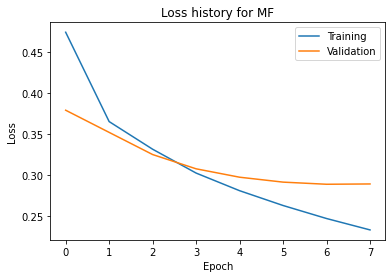

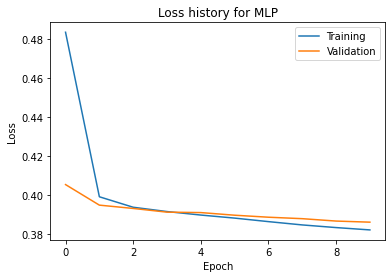

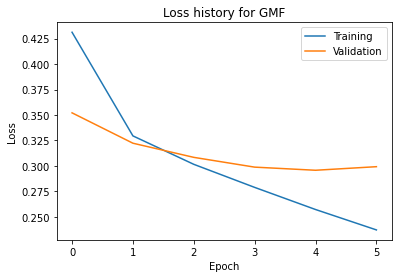

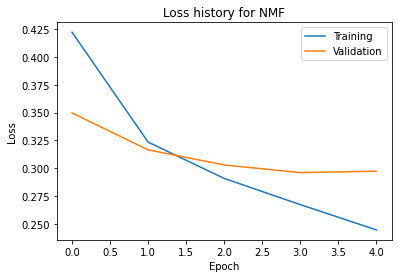

In [35]:
# Plot a separate training and validations plots for each model
for model_name, loss_history in loss_history_per_model.items():
    plt.plot(loss_history["train"], label="Training")
    plt.plot(loss_history["val"], label="Validation")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss history for {model_name}")
    plt.show()


**Training Time:**

Text(0, 0.5, 'Training time in seconds')

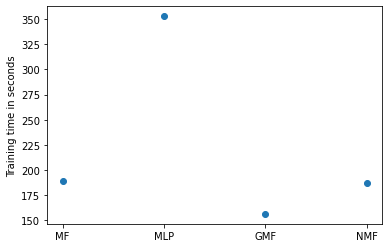

In [36]:
# plot a scatter plot of the training times for each model
plt.scatter(train_times_per_model.keys(), train_times_per_model.values())
# Add y axis label as "Training time in seconds"
plt.ylabel("Training time in seconds")

**Metric Evaluation:**

In [37]:
top_k_values = {
    "5_cutoff": 5,
    "10_cutoff": 10,
}

metric_names = ["mrr", "ndcg", "hit_rate"]
eval_results = {
    "MF": {
        "5_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
        "10_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
    },
    "MLP": {
        "5_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
        "10_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
    },
    "GMF": {
        "5_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
        "10_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
    },
    "NMF": {
        "5_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
        "10_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
    },
}


for top_k_name, top_k_value in top_k_values.items():
        for model_name, model in models.items():
            print(f"Model: {model_name} - Top {top_k_name}")
            mrr, ndcg, hit_rate = model_eval(model, test_ratings, test_neg_vector, top_k_value)
            res_metrics = {
                "mrr": mrr,
                "ndcg": ndcg,
                "hit_rate": hit_rate,
            }
            print(f"mrr: {mrr}, ndcg: {ndcg}, hit_rate: {hit_rate}")
            for metric_name in metric_names:
                eval_results[model_name][top_k_name][metric_name] = res_metrics[metric_name]


Model: MF - Top 5_cutoff


100%|██████████| 6040/6040 [00:04<00:00, 1406.80it/s]


mrr: 0.26747516556291395, ndcg: 0.31501568317012874, hit_rate: 0.4600993377483444
Model: MLP - Top 5_cutoff


100%|██████████| 6040/6040 [00:05<00:00, 1024.42it/s]


mrr: 0.1728587196467991, ndcg: 0.20746541834791277, hit_rate: 0.3130794701986755
Model: GMF - Top 5_cutoff


100%|██████████| 6040/6040 [00:04<00:00, 1314.91it/s]


mrr: 0.2615342163355408, ndcg: 0.30908859307263103, hit_rate: 0.4543046357615894
Model: NMF - Top 5_cutoff


100%|██████████| 6040/6040 [00:06<00:00, 968.47it/s]


mrr: 0.26310706401766004, ndcg: 0.31163036930885574, hit_rate: 0.4594370860927152
Model: MF - Top 10_cutoff


100%|██████████| 6040/6040 [00:05<00:00, 1177.85it/s]


mrr: 0.29116104278355937, ndcg: 0.37284742617880723, hit_rate: 0.6399006622516556
Model: MLP - Top 10_cutoff


100%|██████████| 6040/6040 [00:07<00:00, 853.00it/s]


mrr: 0.1934060627562283, ndcg: 0.25756616345965977, hit_rate: 0.4687086092715232
Model: GMF - Top 10_cutoff


100%|██████████| 6040/6040 [00:05<00:00, 1099.26it/s]


mrr: 0.2857238121517923, ndcg: 0.36764638933373844, hit_rate: 0.6352649006622516
Model: NMF - Top 10_cutoff


100%|██████████| 6040/6040 [00:07<00:00, 850.12it/s]

mrr: 0.28679478082623777, ndcg: 0.369057157789765, hit_rate: 0.6370860927152318


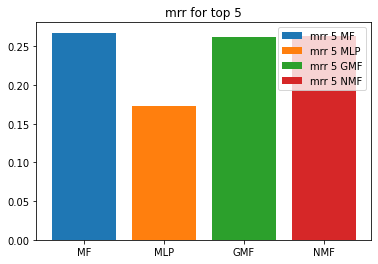

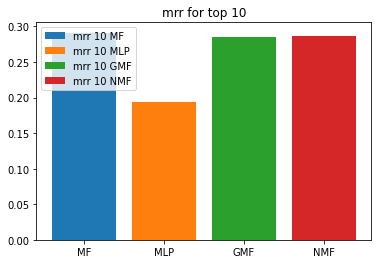

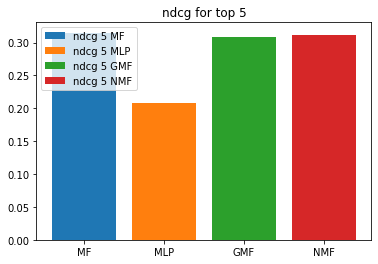

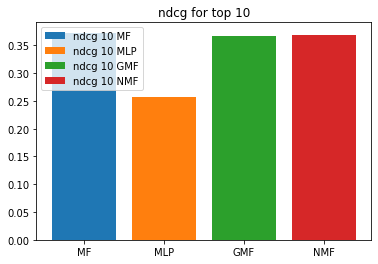

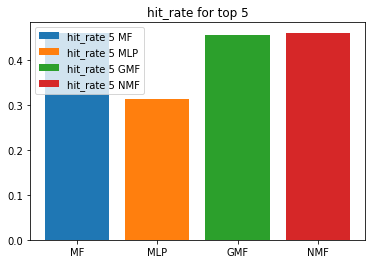

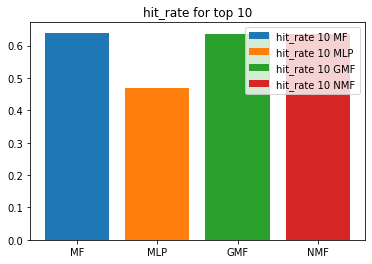

In [38]:
for metric_name in metric_names:
    for top_k_name, top_k_value in top_k_values.items():
        plt.title(f"{metric_name} for top {top_k_value}")
        for model_name, model in models.items():
            plt.bar(model_name, eval_results[model_name][top_k_name][metric_name], label=f"{metric_name} {top_k_value} {model_name}")
        plt.legend()
        plt.show()


<br><br><br><br>
<br><br><br><br>

**c. How do the values of MRR and NDCG differ between your current model and the results you got in the previous exercises which implemented the explicit recommendation approach? What are the differences in preparing the dataset for evaluation?**

Results from previous excersie- MRR:
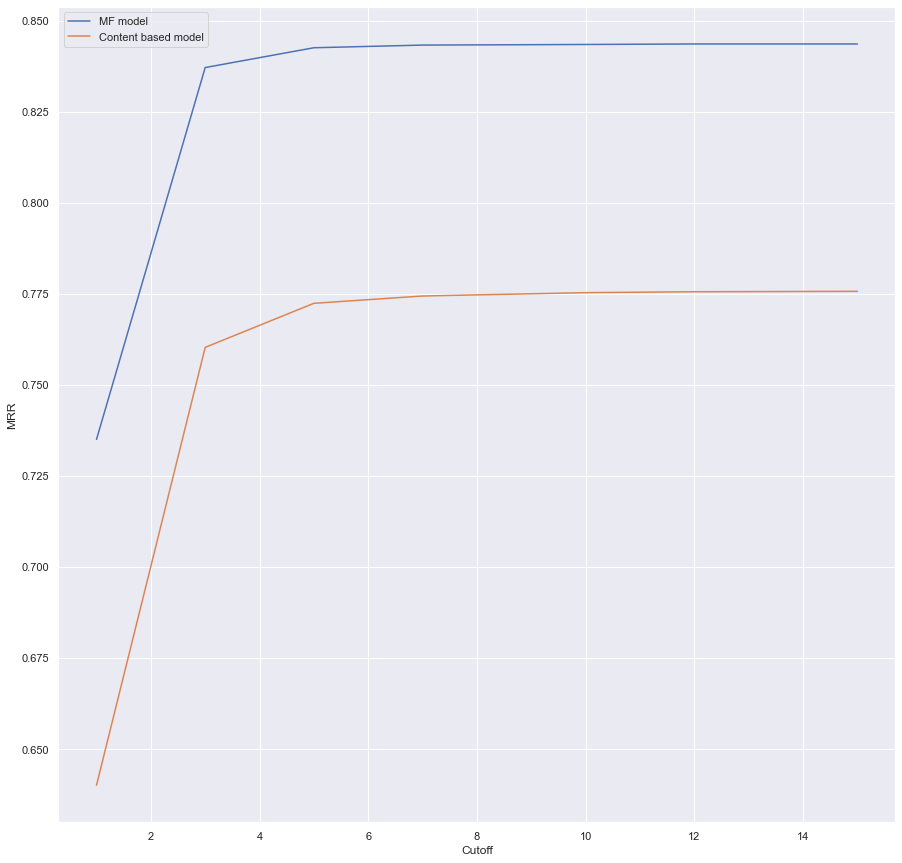

At first glance we can see that the rsults obtained for the NMF are weaker than the results obtained by previous models (CF and CB). There are a few factors to consider when comparing the CF, CB and NMF models. 

1. Previous excersizes used the 100K data, while this one used the 1M set. while the data used here is reacher, is also reduces the probability of scoring a recommendation correctly.
2. The NMF model is evaluated by a leave-one-out approach, while previously we have evaluated by top ranking of multiple predictions per user.

When evaluating the performance of the NCF model, the most recent explicit ranking of each user was evaluated across a model trained on the rest of the data. Hit ratio @10 for the NCF is described as the probablity of having the recent explicit item for a user to be recommended amongst the top 10 items recommended by the model, averaged all users. NDCG (@10) behaves similarly to DCG as the IDCG is normalized the same across all users (assumed as rel1).  



**d. How will you measure item similarity using the NeuMF model?**

We can use the learned representations of the items and then calculate the similarity of the 2 item vectors using either a cosine or euclidean distances. Another way of learning item similarity is by looking at the recommendation the model has generated and the distnace between the ranking 2 items are given for the same user on the average.

## Question 3: Loss Function 
<br><br>

#### a. One of the enhancements presented in the Neural Collaborative Filtering paper is the usage of probabilistic activation function (the sigmoid) and binary cross entropy loss function.    

Select one of the models you implemented in question 2 and change the loss function to a `Mean Squared Error` and the activation function of the last layer to `RELU`.   

Train the model and evaluate it in a similar way to what you did in question 2. 
Compare the results and discuss.

In [39]:
#  added a parameter to control the activation of the last layer on the MLP model
models = {
    "MF": MF(num_users, num_items, embedding_size=32),
    "MLP": MLP(num_users, num_items, embedding_size=16, mlp_layers_sizes=[32, 16, 8], dropout=0.1, ll_activation="ReLU"),
    "GMF": GMF(num_users, num_items,embedding_size=32, ll_activation="ReLU"),
    "NMF": NCF(num_users, num_items, ll_activation="ReLU"),
}

lr_rates = {
    "MF": 0.001,
    "MLP": 0.001,
    "GMF": 0.001,
    "NMF": 0.001,
}

optimizers = {
    "MF": torch.optim.Adam(models["MF"].parameters(), lr=lr_rates["MF"]),
    "MLP": torch.optim.Adam(models["MLP"].parameters(), lr=lr_rates["MLP"]),
    "GMF": torch.optim.Adam(models["GMF"].parameters(), lr=lr_rates["GMF"]),
    "NMF": torch.optim.Adam(models["NMF"].parameters(), lr=lr_rates["NMF"]),
}

batch_sizes = {
    "MF": 256,
    "MLP": 256,
    "GMF": 256,
    "NMF": 256,
}

num_epochs = {
    "MF": num_epoch,
    "MLP": num_epoch,
    "GMF": num_epoch,
    "NMF": num_epoch,
}

# MSE loss for the MLP model
criteria = {
    "NMF": nn.MSELoss(),
    "MF":  nn.MSELoss(),
    "MLP": nn.MSELoss(),
    "GMF": nn.MSELoss(),
}

In [40]:

# Convert all models to use device
for model_name, model in models.items():
    model.to(device)

loss_history_per_model3 = {
    "MF": {
        "train": [],
        "val": [],
    },
    "MLP": {
        "train": [],
        "val": [],
    },
    "GMF": {
        "train": [],
        "val": [],
    },
    "NMF": {
        "train": [],
        "val": [],
    }
}

train_times_per_model3 = {
    "MF": 0,
    "MLP": 0,
    "GMF": 0,
    "NMF": 0,
}

for model_name, model in models.items():
    print(f"Training {model_name}")
    model, train_loss_history3, val_loss_history3, train_time3 = model_train(model, criteria[model_name], optimizers[model_name], None, batch_size=batch_sizes[model_name], num_epochs=num_epochs[model_name],)
    loss_history_per_model3[model_name]["train"] = train_loss_history3
    loss_history_per_model3[model_name]["val"] = val_loss_history3
    train_times_per_model3[model_name] = train_time3

Training MF


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------



0it [00:00, ?it/s]
1it [00:00,  7.43it/s]
35it [00:00, 176.45it/s]
70it [00:00, 246.50it/s]
105it [00:00, 282.73it/s]
139it [00:00, 301.92it/s]
173it [00:00, 313.57it/s]
208it [00:00, 322.54it/s]
243it [00:00, 329.12it/s]
277it [00:00, 331.64it/s]
311it [00:01, 329.56it/s]
345it [00:01, 320.10it/s]
380it [00:01, 327.90it/s]
414it [00:01, 330.47it/s]
449it [00:01, 333.73it/s]
484it [00:01, 336.43it/s]
518it [00:01, 333.01it/s]
552it [00:01, 334.19it/s]
586it [00:01, 335.07it/s]
620it [00:01, 334.74it/s]
655it [00:02, 337.18it/s]
689it [00:02, 337.70it/s]
724it [00:02, 339.34it/s]
758it [00:02, 337.95it/s]
792it [00:02, 336.00it/s]
826it [00:02, 335.55it/s]
860it [00:02, 333.88it/s]
894it [00:02, 334.54it/s]
929it [00:02, 336.87it/s]
963it [00:02, 337.12it/s]
997it [00:03, 336.68it/s]
1031it [00:03, 337.42it/s]
1066it [00:03, 338.90it/s]
1101it [00:03, 339.75it/s]
1135it [00:03, 339.24it/s]
1170it [00:03, 340.15it/s]
1205it [00:03, 338.39it/s]
1239it [00:03, 338.56it/s]
1274it [00:03, 3

Epoch Loss: 0.1640



 10%|█         | 1/10 [00:22<03:26, 22.90s/it]

Epoch Val Loss: 0.1177
Epoch 2/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.78it/s]
34it [00:00, 186.87it/s]
69it [00:00, 257.65it/s]
103it [00:00, 288.34it/s]
133it [00:00, 287.34it/s]
166it [00:00, 299.20it/s]
201it [00:00, 312.82it/s]
236it [00:00, 322.88it/s]
271it [00:00, 329.48it/s]
305it [00:01, 329.46it/s]
339it [00:01, 329.97it/s]
373it [00:01, 323.69it/s]
407it [00:01, 327.93it/s]
440it [00:01, 325.02it/s]
474it [00:01, 328.44it/s]
508it [00:01, 330.64it/s]
543it [00:01, 333.77it/s]
578it [00:01, 335.83it/s]
612it [00:01, 336.13it/s]
646it [00:02, 335.89it/s]
680it [00:02, 336.55it/s]
714it [00:02, 336.77it/s]
749it [00:02, 339.06it/s]
783it [00:02, 331.66it/s]
818it [00:02, 334.37it/s]
853it [00:02, 336.70it/s]
888it [00:02, 338.69it/s]
922it [00:02, 338.72it/s]
957it [00:02, 340.36it/s]
992it [00:03, 340.29it/s]
1027it [00:03, 338.36it/s]
1061it [00:03, 336.53it/s]
1096it [00:03, 338.28it/s]
1131it [00:03, 339.19it/s]
1166it [00:03, 339.83it/s]
1200it [00:03, 338.87it/s]
1235it [00:03, 340.93it/s]
1270it [00:03, 3

Epoch Loss: 0.1074



 20%|██        | 2/10 [00:45<03:03, 22.88s/it]

Epoch Val Loss: 0.1016
Epoch 3/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.80it/s]
35it [00:00, 191.21it/s]
70it [00:00, 258.91it/s]
105it [00:00, 292.24it/s]
140it [00:00, 311.25it/s]
173it [00:00, 316.81it/s]
208it [00:00, 325.05it/s]
242it [00:00, 329.65it/s]
276it [00:00, 323.90it/s]
310it [00:01, 326.60it/s]
345it [00:01, 331.20it/s]
380it [00:01, 335.61it/s]
415it [00:01, 338.87it/s]
449it [00:01, 336.67it/s]
483it [00:01, 336.58it/s]
517it [00:01, 337.21it/s]
551it [00:01, 335.15it/s]
586it [00:01, 336.78it/s]
620it [00:01, 335.83it/s]
654it [00:02, 333.62it/s]
688it [00:02, 335.03it/s]
722it [00:02, 336.35it/s]
756it [00:02, 334.34it/s]
791it [00:02, 336.41it/s]
825it [00:02, 336.54it/s]
859it [00:02, 334.49it/s]
893it [00:02, 335.97it/s]
928it [00:02, 338.68it/s]
962it [00:02, 333.33it/s]
996it [00:03, 335.02it/s]
1030it [00:03, 335.60it/s]
1064it [00:03, 335.25it/s]
1099it [00:03, 338.14it/s]
1133it [00:03, 333.13it/s]
1167it [00:03, 331.22it/s]
1201it [00:03, 329.61it/s]
1235it [00:03, 332.43it/s]
1270it [00:03, 3

Epoch Loss: 0.0929



 30%|███       | 3/10 [01:08<02:40, 22.86s/it]

Epoch Val Loss: 0.0954
Epoch 4/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.80it/s]
35it [00:00, 190.48it/s]
69it [00:00, 255.82it/s]
103it [00:00, 287.65it/s]
137it [00:00, 305.24it/s]
170it [00:00, 310.92it/s]
203it [00:00, 316.73it/s]
236it [00:00, 319.46it/s]
270it [00:00, 325.07it/s]
304it [00:01, 329.61it/s]
338it [00:01, 328.38it/s]
371it [00:01, 327.78it/s]
404it [00:01, 328.36it/s]
438it [00:01, 330.69it/s]
472it [00:01, 329.99it/s]
506it [00:01, 330.36it/s]
540it [00:01, 326.78it/s]
574it [00:01, 328.70it/s]
608it [00:01, 329.52it/s]
641it [00:02, 327.66it/s]
676it [00:02, 332.19it/s]
710it [00:02, 327.20it/s]
743it [00:02, 327.83it/s]
777it [00:02, 329.26it/s]
811it [00:02, 330.70it/s]
845it [00:02, 323.26it/s]
878it [00:02, 323.31it/s]
912it [00:02, 328.17it/s]
947it [00:02, 331.89it/s]
981it [00:03, 333.66it/s]
1016it [00:03, 336.19it/s]
1050it [00:03, 336.76it/s]
1084it [00:03, 337.60it/s]
1119it [00:03, 339.31it/s]
1153it [00:03, 337.58it/s]
1187it [00:03, 333.68it/s]
1221it [00:03, 334.25it/s]
1256it [00:03, 3

Epoch Loss: 0.0844



 40%|████      | 4/10 [01:31<02:17, 22.90s/it]

Epoch Val Loss: 0.0936
Epoch 5/10
----------



0it [00:00, ?it/s]
1it [00:00,  9.16it/s]
32it [00:00, 177.90it/s]
66it [00:00, 248.89it/s]
100it [00:00, 283.29it/s]
134it [00:00, 300.87it/s]
168it [00:00, 311.67it/s]
202it [00:00, 317.94it/s]
234it [00:00, 316.55it/s]
267it [00:00, 320.17it/s]
301it [00:01, 323.91it/s]
335it [00:01, 326.85it/s]
368it [00:01, 327.69it/s]
402it [00:01, 329.58it/s]
435it [00:01, 328.95it/s]
468it [00:01, 327.85it/s]
501it [00:01, 324.00it/s]
534it [00:01, 324.54it/s]
567it [00:01, 325.35it/s]
601it [00:01, 327.14it/s]
635it [00:02, 329.78it/s]
669it [00:02, 330.66it/s]
703it [00:02, 332.29it/s]
737it [00:02, 332.66it/s]
771it [00:02, 333.69it/s]
805it [00:02, 334.69it/s]
839it [00:02, 321.50it/s]
873it [00:02, 325.20it/s]
907it [00:02, 328.91it/s]
941it [00:02, 330.76it/s]
975it [00:03, 331.81it/s]
1010it [00:03, 335.12it/s]
1044it [00:03, 336.34it/s]
1079it [00:03, 337.73it/s]
1113it [00:03, 335.13it/s]
1147it [00:03, 333.83it/s]
1181it [00:03, 333.93it/s]
1215it [00:03, 333.57it/s]
1249it [00:03, 3

Epoch Loss: 0.0792



 40%|████      | 4/10 [01:54<02:51, 28.65s/it]


Epoch Val Loss: 0.0940
Early stopping
Training MLP


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.80it/s]
22it [00:00, 120.40it/s]
44it [00:00, 161.35it/s]
66it [00:00, 180.94it/s]
88it [00:00, 193.56it/s]
111it [00:00, 203.06it/s]
133it [00:00, 207.38it/s]
155it [00:00, 209.48it/s]
177it [00:00, 208.05it/s]
199it [00:01, 210.57it/s]
221it [00:01, 212.09it/s]
243it [00:01, 212.73it/s]
266it [00:01, 215.27it/s]
288it [00:01, 215.35it/s]
310it [00:01, 215.08it/s]
332it [00:01, 216.03it/s]
354it [00:01, 213.06it/s]
376it [00:01, 215.06it/s]
398it [00:01, 216.49it/s]
420it [00:02, 214.02it/s]
442it [00:02, 215.62it/s]
464it [00:02, 216.06it/s]
486it [00:02, 217.03it/s]
508it [00:02, 216.22it/s]
531it [00:02, 217.53it/s]
554it [00:02, 219.23it/s]
576it [00:02, 215.56it/s]
598it [00:02, 213.63it/s]
620it [00:02, 214.79it/s]
642it [00:03, 214.97it/s]
664it [00:03, 215.17it/s]
686it [00:03, 214.93it/s]
708it [00:03, 213.39it/s]
730it [00:03, 214.06it/s]
752it [00:03, 214.40it/s]
774it [00:03, 214.42it/s]
796it [00:03, 212.10it/s]
818it [00:03, 212.77it/s]

Epoch Loss: 0.1666



 10%|█         | 1/10 [00:34<05:11, 34.65s/it]

Epoch Val Loss: 0.1334
Epoch 2/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.69it/s]
23it [00:00, 125.16it/s]
45it [00:00, 165.69it/s]
67it [00:00, 185.66it/s]
89it [00:00, 197.31it/s]
111it [00:00, 204.76it/s]
132it [00:00, 206.03it/s]
154it [00:00, 209.75it/s]
176it [00:00, 212.82it/s]
198it [00:01, 212.82it/s]
220it [00:01, 213.57it/s]
243it [00:01, 216.11it/s]
265it [00:01, 216.62it/s]
287it [00:01, 216.88it/s]
309it [00:01, 216.05it/s]
331it [00:01, 213.44it/s]
353it [00:01, 214.64it/s]
375it [00:01, 216.04it/s]
397it [00:01, 215.55it/s]
419it [00:02, 214.71it/s]
441it [00:02, 215.26it/s]
463it [00:02, 215.91it/s]
485it [00:02, 216.71it/s]
507it [00:02, 217.68it/s]
529it [00:02, 217.68it/s]
551it [00:02, 217.81it/s]
573it [00:02, 217.87it/s]
595it [00:02, 217.60it/s]
618it [00:02, 219.00it/s]
640it [00:03, 217.93it/s]
662it [00:03, 217.52it/s]
684it [00:03, 216.06it/s]
707it [00:03, 217.40it/s]
730it [00:03, 219.09it/s]
752it [00:03, 218.93it/s]
774it [00:03, 218.80it/s]
796it [00:03, 216.84it/s]
818it [00:03, 210.65it/s]

Epoch Loss: 0.1305



 20%|██        | 2/10 [01:09<04:37, 34.71s/it]

Epoch Val Loss: 0.1289
Epoch 3/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.66it/s]
23it [00:00, 124.54it/s]
45it [00:00, 166.07it/s]
67it [00:00, 186.28it/s]
89it [00:00, 196.91it/s]
111it [00:00, 204.41it/s]
134it [00:00, 210.48it/s]
156it [00:00, 211.44it/s]
178it [00:00, 212.09it/s]
200it [00:01, 213.55it/s]
222it [00:01, 214.26it/s]
244it [00:01, 214.52it/s]
266it [00:01, 213.28it/s]
288it [00:01, 214.91it/s]
310it [00:01, 215.44it/s]
333it [00:01, 217.50it/s]
355it [00:01, 217.75it/s]
377it [00:01, 217.53it/s]
399it [00:01, 215.47it/s]
422it [00:02, 217.62it/s]
444it [00:02, 217.12it/s]
466it [00:02, 217.68it/s]
488it [00:02, 212.91it/s]
510it [00:02, 212.88it/s]
532it [00:02, 214.47it/s]
554it [00:02, 215.74it/s]
576it [00:02, 216.67it/s]
598it [00:02, 217.65it/s]
620it [00:02, 217.21it/s]
642it [00:03, 215.00it/s]
664it [00:03, 214.67it/s]
686it [00:03, 214.59it/s]
708it [00:03, 214.27it/s]
730it [00:03, 214.66it/s]
752it [00:03, 216.19it/s]
774it [00:03, 217.03it/s]
797it [00:03, 218.66it/s]
819it [00:03, 218.34it/s]

Epoch Loss: 0.1282



 30%|███       | 3/10 [01:44<04:03, 34.73s/it]

Epoch Val Loss: 0.1280
Epoch 4/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.42it/s]
22it [00:00, 116.75it/s]
43it [00:00, 156.70it/s]
65it [00:00, 180.84it/s]
88it [00:00, 195.29it/s]
110it [00:00, 202.46it/s]
132it [00:00, 205.88it/s]
154it [00:00, 209.88it/s]
176it [00:00, 211.66it/s]
198it [00:01, 213.88it/s]
221it [00:01, 216.25it/s]
244it [00:01, 217.66it/s]
266it [00:01, 218.22it/s]
289it [00:01, 219.13it/s]
312it [00:01, 219.85it/s]
334it [00:01, 217.48it/s]
356it [00:01, 217.70it/s]
378it [00:01, 218.20it/s]
400it [00:01, 212.68it/s]
422it [00:02, 214.62it/s]
444it [00:02, 215.23it/s]
466it [00:02, 216.45it/s]
488it [00:02, 213.11it/s]
510it [00:02, 213.91it/s]
532it [00:02, 214.97it/s]
554it [00:02, 216.34it/s]
577it [00:02, 217.88it/s]
599it [00:02, 217.78it/s]
621it [00:02, 217.86it/s]
643it [00:03, 217.92it/s]
665it [00:03, 217.63it/s]
688it [00:03, 218.85it/s]
710it [00:03, 218.36it/s]
732it [00:03, 216.51it/s]
754it [00:03, 215.47it/s]
776it [00:03, 215.10it/s]
798it [00:03, 215.51it/s]
820it [00:03, 216.08it/s]

Epoch Loss: 0.1275



 40%|████      | 4/10 [02:18<03:28, 34.73s/it]

Epoch Val Loss: 0.1275
Epoch 5/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.99it/s]
23it [00:00, 126.92it/s]
45it [00:00, 168.00it/s]
67it [00:00, 186.40it/s]
90it [00:00, 199.17it/s]
111it [00:00, 201.82it/s]
133it [00:00, 207.57it/s]
156it [00:00, 211.97it/s]
178it [00:00, 214.11it/s]
200it [00:01, 215.10it/s]
222it [00:01, 216.49it/s]
245it [00:01, 217.70it/s]
268it [00:01, 218.74it/s]
290it [00:01, 218.81it/s]
312it [00:01, 218.27it/s]
334it [00:01, 218.10it/s]
356it [00:01, 215.28it/s]
378it [00:01, 215.86it/s]
400it [00:01, 215.97it/s]
422it [00:02, 208.14it/s]
444it [00:02, 211.14it/s]
467it [00:02, 214.17it/s]
489it [00:02, 215.50it/s]
511it [00:02, 216.42it/s]
533it [00:02, 216.17it/s]
555it [00:02, 216.13it/s]
578it [00:02, 217.78it/s]
600it [00:02, 217.75it/s]
622it [00:02, 216.57it/s]
644it [00:03, 214.07it/s]
666it [00:03, 215.59it/s]
688it [00:03, 216.29it/s]
710it [00:03, 216.44it/s]
732it [00:03, 216.78it/s]
755it [00:03, 217.91it/s]
777it [00:03, 217.46it/s]
800it [00:03, 218.59it/s]
822it [00:03, 216.19it/s]

Epoch Loss: 0.1268



 50%|█████     | 5/10 [02:53<02:53, 34.71s/it]

Epoch Val Loss: 0.1273
Epoch 6/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.75it/s]
21it [00:00, 113.32it/s]
43it [00:00, 159.45it/s]
65it [00:00, 181.36it/s]
87it [00:00, 193.94it/s]
110it [00:00, 203.64it/s]
132it [00:00, 207.72it/s]
154it [00:00, 210.71it/s]
176it [00:00, 212.95it/s]
198it [00:01, 213.72it/s]
220it [00:01, 215.09it/s]
242it [00:01, 212.75it/s]
264it [00:01, 214.19it/s]
286it [00:01, 215.76it/s]
309it [00:01, 218.18it/s]
332it [00:01, 219.23it/s]
355it [00:01, 219.63it/s]
377it [00:01, 218.13it/s]
399it [00:01, 217.39it/s]
421it [00:02, 217.20it/s]
443it [00:02, 217.60it/s]
465it [00:02, 213.20it/s]
487it [00:02, 214.83it/s]
509it [00:02, 215.01it/s]
531it [00:02, 213.32it/s]
554it [00:02, 215.60it/s]
577it [00:02, 217.88it/s]
599it [00:02, 215.49it/s]
622it [00:02, 216.92it/s]
644it [00:03, 216.68it/s]
666it [00:03, 216.02it/s]
688it [00:03, 216.80it/s]
710it [00:03, 216.12it/s]
732it [00:03, 215.20it/s]
754it [00:03, 215.33it/s]
776it [00:03, 212.09it/s]
798it [00:03, 211.02it/s]
820it [00:03, 211.99it/s]

Epoch Loss: 0.1265



 60%|██████    | 6/10 [03:28<02:18, 34.72s/it]

Epoch Val Loss: 0.1269
Epoch 7/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.78it/s]
21it [00:00, 115.10it/s]
43it [00:00, 159.93it/s]
65it [00:00, 180.50it/s]
87it [00:00, 193.46it/s]
109it [00:00, 200.34it/s]
131it [00:00, 205.90it/s]
153it [00:00, 209.96it/s]
175it [00:00, 211.07it/s]
197it [00:01, 213.67it/s]
219it [00:01, 215.45it/s]
241it [00:01, 213.74it/s]
264it [00:01, 216.35it/s]
286it [00:01, 212.87it/s]
308it [00:01, 211.43it/s]
330it [00:01, 211.30it/s]
352it [00:01, 211.86it/s]
374it [00:01, 212.40it/s]
396it [00:01, 213.36it/s]
419it [00:02, 216.18it/s]
441it [00:02, 215.61it/s]
463it [00:02, 212.04it/s]
486it [00:02, 214.58it/s]
508it [00:02, 210.77it/s]
530it [00:02, 213.07it/s]
552it [00:02, 214.22it/s]
574it [00:02, 212.94it/s]
596it [00:02, 212.30it/s]
618it [00:03, 213.95it/s]
640it [00:03, 215.18it/s]
663it [00:03, 217.23it/s]
685it [00:03, 217.59it/s]
707it [00:03, 214.65it/s]
729it [00:03, 214.89it/s]
751it [00:03, 215.98it/s]
773it [00:03, 216.16it/s]
796it [00:03, 217.69it/s]
819it [00:03, 218.88it/s]

Epoch Loss: 0.1262



 60%|██████    | 6/10 [04:03<02:42, 40.51s/it]


Epoch Val Loss: 0.1271
Early stopping
Training GMF


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.94it/s]
30it [00:00, 166.49it/s]
59it [00:00, 219.63it/s]
90it [00:00, 252.71it/s]
119it [00:00, 264.85it/s]
149it [00:00, 275.50it/s]
179it [00:00, 281.59it/s]
210it [00:00, 288.25it/s]
240it [00:00, 291.26it/s]
270it [00:01, 291.91it/s]
300it [00:01, 293.33it/s]
330it [00:01, 292.74it/s]
360it [00:01, 294.03it/s]
390it [00:01, 294.82it/s]
420it [00:01, 294.56it/s]
450it [00:01, 290.55it/s]
480it [00:01, 292.49it/s]
510it [00:01, 290.08it/s]
540it [00:01, 291.60it/s]
570it [00:02, 290.93it/s]
600it [00:02, 293.45it/s]
631it [00:02, 296.04it/s]
661it [00:02, 294.94it/s]
691it [00:02, 295.68it/s]
721it [00:02, 295.42it/s]
751it [00:02, 295.72it/s]
781it [00:02, 296.79it/s]
811it [00:02, 281.97it/s]
841it [00:02, 285.10it/s]
872it [00:03, 290.49it/s]
902it [00:03, 288.90it/s]
931it [00:03, 289.14it/s]
962it [00:03, 292.74it/s]
992it [00:03, 288.45it/s]
1022it [00:03, 290.99it/s]
1052it [00:03, 292.15it/s]
1082it [00:03, 292.57it/s]
1112it [00:03, 293.51

Epoch Loss: 0.1398



 10%|█         | 1/10 [00:25<03:52, 25.81s/it]

Epoch Val Loss: 0.1078
Epoch 2/10
----------



0it [00:00, ?it/s]
1it [00:00,  9.06it/s]
30it [00:00, 166.50it/s]
60it [00:00, 223.30it/s]
90it [00:00, 252.10it/s]
121it [00:00, 270.21it/s]
151it [00:00, 279.97it/s]
181it [00:00, 285.41it/s]
211it [00:00, 289.36it/s]
241it [00:00, 290.27it/s]
272it [00:01, 293.64it/s]
302it [00:01, 293.29it/s]
332it [00:01, 293.76it/s]
362it [00:01, 292.29it/s]
392it [00:01, 288.67it/s]
422it [00:01, 289.88it/s]
453it [00:01, 293.50it/s]
483it [00:01, 294.96it/s]
513it [00:01, 294.79it/s]
543it [00:01, 295.08it/s]
574it [00:02, 296.82it/s]
604it [00:02, 296.04it/s]
634it [00:02, 296.70it/s]
664it [00:02, 296.05it/s]
694it [00:02, 294.57it/s]
724it [00:02, 295.73it/s]
754it [00:02, 296.50it/s]
784it [00:02, 295.89it/s]
814it [00:02, 294.95it/s]
844it [00:02, 294.34it/s]
874it [00:03, 293.90it/s]
904it [00:03, 287.62it/s]
935it [00:03, 292.32it/s]
966it [00:03, 294.78it/s]
997it [00:03, 297.43it/s]
1028it [00:03, 298.64it/s]
1058it [00:03, 296.73it/s]
1088it [00:03, 295.72it/s]
1118it [00:03, 295.12

Epoch Loss: 0.0980



 20%|██        | 2/10 [00:51<03:27, 25.90s/it]

Epoch Val Loss: 0.0962
Epoch 3/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.86it/s]
31it [00:00, 168.76it/s]
62it [00:00, 228.07it/s]
91it [00:00, 251.46it/s]
120it [00:00, 265.01it/s]
151it [00:00, 277.30it/s]
181it [00:00, 284.20it/s]
212it [00:00, 290.14it/s]
242it [00:00, 291.04it/s]
273it [00:01, 294.50it/s]
303it [00:01, 295.54it/s]
334it [00:01, 298.60it/s]
364it [00:01, 298.71it/s]
394it [00:01, 298.66it/s]
424it [00:01, 296.88it/s]
454it [00:01, 297.08it/s]
484it [00:01, 292.21it/s]
514it [00:01, 294.24it/s]
544it [00:01, 292.61it/s]
574it [00:02, 293.90it/s]
604it [00:02, 294.67it/s]
635it [00:02, 296.94it/s]
666it [00:02, 298.34it/s]
696it [00:02, 297.92it/s]
726it [00:02, 297.60it/s]
757it [00:02, 299.26it/s]
788it [00:02, 300.60it/s]
819it [00:02, 299.52it/s]
849it [00:02, 289.28it/s]
879it [00:03, 292.25it/s]
909it [00:03, 293.51it/s]
940it [00:03, 295.72it/s]
971it [00:03, 297.86it/s]
1001it [00:03, 296.21it/s]
1031it [00:03, 296.57it/s]
1062it [00:03, 298.11it/s]
1092it [00:03, 296.59it/s]
1122it [00:03, 296.0

Epoch Loss: 0.0859



 30%|███       | 3/10 [01:17<03:00, 25.83s/it]

Epoch Val Loss: 0.0924
Epoch 4/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.85it/s]
31it [00:00, 169.28it/s]
61it [00:00, 226.09it/s]
92it [00:00, 255.88it/s]
123it [00:00, 273.02it/s]
151it [00:00, 271.15it/s]
181it [00:00, 280.29it/s]
211it [00:00, 286.01it/s]
241it [00:00, 287.33it/s]
272it [00:01, 291.47it/s]
303it [00:01, 294.26it/s]
333it [00:01, 295.02it/s]
363it [00:01, 293.67it/s]
393it [00:01, 294.44it/s]
423it [00:01, 295.56it/s]
453it [00:01, 296.14it/s]
483it [00:01, 296.30it/s]
513it [00:01, 296.40it/s]
544it [00:01, 297.57it/s]
575it [00:02, 298.54it/s]
605it [00:02, 298.52it/s]
635it [00:02, 297.00it/s]
666it [00:02, 298.53it/s]
697it [00:02, 299.57it/s]
728it [00:02, 300.97it/s]
759it [00:02, 297.89it/s]
789it [00:02, 297.11it/s]
820it [00:02, 298.69it/s]
850it [00:02, 297.98it/s]
881it [00:03, 299.83it/s]
911it [00:03, 297.36it/s]
941it [00:03, 298.11it/s]
972it [00:03, 299.87it/s]
1003it [00:03, 300.13it/s]
1034it [00:03, 300.37it/s]
1065it [00:03, 299.32it/s]
1095it [00:03, 297.79it/s]
1125it [00:03, 295.7

Epoch Loss: 0.0783



 40%|████      | 4/10 [01:43<02:34, 25.83s/it]

Epoch Val Loss: 0.0917
Epoch 5/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.93it/s]
31it [00:00, 171.08it/s]
61it [00:00, 225.94it/s]
90it [00:00, 249.40it/s]
121it [00:00, 268.45it/s]
152it [00:00, 280.41it/s]
182it [00:00, 285.86it/s]
212it [00:00, 288.29it/s]
242it [00:00, 289.59it/s]
272it [00:01, 290.96it/s]
303it [00:01, 294.26it/s]
333it [00:01, 295.37it/s]
364it [00:01, 296.63it/s]
394it [00:01, 296.98it/s]
424it [00:01, 296.24it/s]
454it [00:01, 295.73it/s]
485it [00:01, 297.61it/s]
515it [00:01, 297.18it/s]
545it [00:01, 294.86it/s]
575it [00:02, 296.08it/s]
605it [00:02, 293.24it/s]
635it [00:02, 289.95it/s]
665it [00:02, 291.10it/s]
695it [00:02, 292.62it/s]
725it [00:02, 290.64it/s]
755it [00:02, 291.82it/s]
785it [00:02, 293.54it/s]
816it [00:02, 295.59it/s]
846it [00:02, 295.27it/s]
876it [00:03, 295.31it/s]
906it [00:03, 295.16it/s]
936it [00:03, 296.22it/s]
966it [00:03, 295.17it/s]
996it [00:03, 288.77it/s]
1025it [00:03, 285.67it/s]
1055it [00:03, 288.15it/s]
1085it [00:03, 290.31it/s]
1116it [00:03, 294.07

Epoch Loss: 0.0728



 40%|████      | 4/10 [02:09<03:13, 32.29s/it]


Epoch Val Loss: 0.0921
Early stopping
Training NMF


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------



0it [00:00, ?it/s]
1it [00:00,  9.13it/s]
21it [00:00, 116.05it/s]
42it [00:00, 155.03it/s]
63it [00:00, 173.75it/s]
84it [00:00, 184.40it/s]
103it [00:00, 183.54it/s]
124it [00:00, 190.50it/s]
145it [00:00, 194.99it/s]
166it [00:00, 197.70it/s]
187it [00:01, 199.63it/s]
208it [00:01, 201.86it/s]
229it [00:01, 201.46it/s]
250it [00:01, 191.18it/s]
271it [00:01, 195.79it/s]
291it [00:01, 196.85it/s]
311it [00:01, 197.20it/s]
332it [00:01, 198.66it/s]
352it [00:01, 198.79it/s]
373it [00:01, 200.86it/s]
394it [00:02, 201.45it/s]
415it [00:02, 195.46it/s]
436it [00:02, 197.89it/s]
457it [00:02, 199.85it/s]
478it [00:02, 200.35it/s]
499it [00:02, 201.42it/s]
520it [00:02, 201.44it/s]
541it [00:02, 200.55it/s]
562it [00:02, 201.88it/s]
583it [00:03, 202.23it/s]
604it [00:03, 201.88it/s]
625it [00:03, 199.92it/s]
646it [00:03, 200.50it/s]
667it [00:03, 200.36it/s]
688it [00:03, 199.74it/s]
709it [00:03, 200.77it/s]
730it [00:03, 202.05it/s]
751it [00:03, 202.11it/s]
772it [00:03, 203.27it/s]

Epoch Loss: 0.1339



 10%|█         | 1/10 [00:37<05:35, 37.33s/it]

Epoch Val Loss: 0.1052
Epoch 2/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.85it/s]
21it [00:00, 113.36it/s]
41it [00:00, 150.99it/s]
61it [00:00, 168.34it/s]
82it [00:00, 181.55it/s]
102it [00:00, 187.57it/s]
123it [00:00, 193.65it/s]
144it [00:00, 196.79it/s]
165it [00:00, 198.46it/s]
186it [00:01, 199.33it/s]
206it [00:01, 196.15it/s]
226it [00:01, 196.64it/s]
247it [00:01, 199.08it/s]
268it [00:01, 200.07it/s]
289it [00:01, 201.13it/s]
310it [00:01, 201.51it/s]
331it [00:01, 197.08it/s]
352it [00:01, 198.21it/s]
373it [00:01, 199.15it/s]
394it [00:02, 201.25it/s]
415it [00:02, 200.70it/s]
436it [00:02, 201.19it/s]
457it [00:02, 202.06it/s]
478it [00:02, 202.19it/s]
499it [00:02, 202.82it/s]
520it [00:02, 201.25it/s]
541it [00:02, 199.45it/s]
562it [00:02, 201.86it/s]
583it [00:03, 202.49it/s]
604it [00:03, 203.63it/s]
625it [00:03, 203.81it/s]
646it [00:03, 200.80it/s]
667it [00:03, 202.33it/s]
688it [00:03, 203.19it/s]
709it [00:03, 203.39it/s]
730it [00:03, 203.42it/s]
751it [00:03, 196.85it/s]
771it [00:03, 196.91it/s]

Epoch Loss: 0.0955



 20%|██        | 2/10 [01:14<04:57, 37.19s/it]

Epoch Val Loss: 0.0962
Epoch 3/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.57it/s]
17it [00:00, 90.31it/s]
37it [00:00, 137.97it/s]
58it [00:00, 162.56it/s]
79it [00:00, 177.00it/s]
100it [00:00, 185.88it/s]
121it [00:00, 190.72it/s]
141it [00:00, 193.37it/s]
162it [00:00, 196.05it/s]
182it [00:01, 196.13it/s]
203it [00:01, 197.59it/s]
223it [00:01, 196.94it/s]
244it [00:01, 198.74it/s]
265it [00:01, 200.40it/s]
286it [00:01, 195.96it/s]
307it [00:01, 197.98it/s]
327it [00:01, 198.43it/s]
347it [00:01, 198.77it/s]
368it [00:01, 200.34it/s]
389it [00:02, 200.97it/s]
410it [00:02, 200.81it/s]
431it [00:02, 200.73it/s]
452it [00:02, 200.30it/s]
473it [00:02, 201.42it/s]
494it [00:02, 200.85it/s]
515it [00:02, 200.48it/s]
536it [00:02, 201.64it/s]
557it [00:02, 202.99it/s]
578it [00:03, 202.69it/s]
599it [00:03, 195.72it/s]
620it [00:03, 197.73it/s]
640it [00:03, 197.22it/s]
661it [00:03, 198.28it/s]
681it [00:03, 194.37it/s]
701it [00:03, 195.26it/s]
721it [00:03, 196.55it/s]
742it [00:03, 198.21it/s]
762it [00:03, 198.64it/s]


Epoch Loss: 0.0847



 30%|███       | 3/10 [01:51<04:20, 37.23s/it]

Epoch Val Loss: 0.0933
Epoch 4/10
----------



0it [00:00, ?it/s]
1it [00:00,  8.68it/s]
21it [00:00, 114.56it/s]
42it [00:00, 153.41it/s]
62it [00:00, 169.75it/s]
83it [00:00, 182.21it/s]
104it [00:00, 187.36it/s]
124it [00:00, 190.79it/s]
144it [00:00, 192.38it/s]
165it [00:00, 195.41it/s]
185it [00:01, 193.10it/s]
205it [00:01, 189.39it/s]
226it [00:01, 194.31it/s]
247it [00:01, 197.04it/s]
267it [00:01, 197.82it/s]
288it [00:01, 199.08it/s]
309it [00:01, 200.35it/s]
330it [00:01, 200.66it/s]
351it [00:01, 200.25it/s]
372it [00:01, 197.96it/s]
393it [00:02, 199.78it/s]
413it [00:02, 199.65it/s]
434it [00:02, 200.59it/s]
455it [00:02, 201.54it/s]
476it [00:02, 201.20it/s]
497it [00:02, 203.03it/s]
518it [00:02, 202.29it/s]
539it [00:02, 202.58it/s]
560it [00:02, 203.27it/s]
581it [00:03, 203.00it/s]
602it [00:03, 198.65it/s]
622it [00:03, 197.04it/s]
642it [00:03, 197.86it/s]
662it [00:03, 197.92it/s]
682it [00:03, 198.06it/s]
703it [00:03, 200.08it/s]
724it [00:03, 201.19it/s]
745it [00:03, 200.85it/s]
766it [00:03, 202.40it/s]

Epoch Loss: 0.0772



 40%|████      | 4/10 [02:28<03:43, 37.19s/it]

Epoch Val Loss: 0.0929
Epoch 5/10
----------



0it [00:00, ?it/s]
1it [00:00,  9.19it/s]
21it [00:00, 116.98it/s]
42it [00:00, 156.19it/s]
63it [00:00, 174.67it/s]
84it [00:00, 186.17it/s]
105it [00:00, 192.23it/s]
125it [00:00, 193.41it/s]
145it [00:00, 190.29it/s]
166it [00:00, 194.35it/s]
187it [00:01, 197.06it/s]
208it [00:01, 199.68it/s]
229it [00:01, 201.39it/s]
250it [00:01, 202.79it/s]
271it [00:01, 203.12it/s]
292it [00:01, 201.92it/s]
313it [00:01, 202.70it/s]
334it [00:01, 202.64it/s]
355it [00:01, 201.04it/s]
376it [00:01, 200.66it/s]
397it [00:02, 201.15it/s]
418it [00:02, 202.05it/s]
439it [00:02, 202.55it/s]
460it [00:02, 202.37it/s]
481it [00:02, 203.46it/s]
502it [00:02, 204.60it/s]
523it [00:02, 204.88it/s]
544it [00:02, 202.76it/s]
565it [00:02, 197.43it/s]
586it [00:03, 198.83it/s]
606it [00:03, 198.07it/s]
626it [00:03, 194.43it/s]
647it [00:03, 196.32it/s]
668it [00:03, 198.10it/s]
689it [00:03, 200.31it/s]
710it [00:03, 201.55it/s]
731it [00:03, 196.84it/s]
752it [00:03, 198.01it/s]
773it [00:03, 199.15it/s]

Epoch Loss: 0.0721



 40%|████      | 4/10 [03:05<04:38, 46.48s/it]

Epoch Val Loss: 0.0933
Early stopping


# New Section

<br><br><br>
<br><br><br>

Train & Validation Loss:

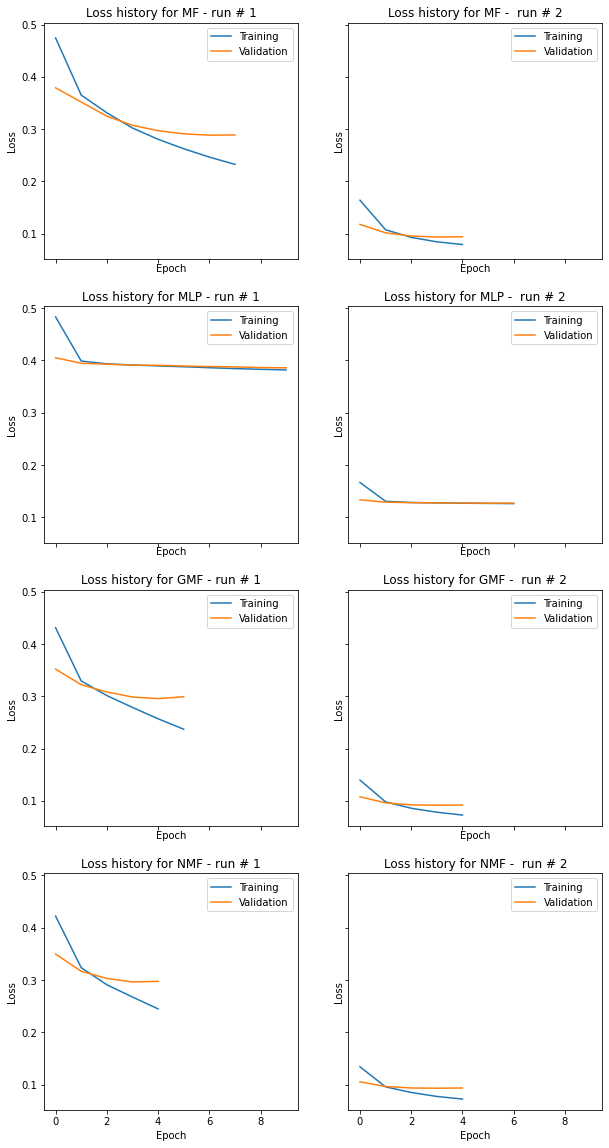

In [41]:
# Plot a separate training and validations plots for each model
fig, axs = plt.subplots(4, 2, figsize=(10, 20), sharex=True, sharey=True)
p = 0
for model_name, loss_history in loss_history_per_model.items():
    axs[p, 0].plot(loss_history["train"], label="Training")
    axs[p, 0].plot(loss_history["val"], label="Validation")
    axs[p, 0].legend()
    axs[p, 0].set(xlabel="Epoch", ylabel="Loss")
    axs[p, 0].set_title(f"Loss history for {model_name} - run # 1")
    # plt.show()
    p += 1

p = 0
for model_name, loss_history in loss_history_per_model3.items():
    axs[p, 1].plot(loss_history["train"], label="Training")
    axs[p, 1].plot(loss_history["val"], label="Validation")
    axs[p, 1].legend()
    axs[p, 1].set(xlabel="Epoch", ylabel="Loss")
    axs[p, 1].set_title(f"Loss history for {model_name} -  run # 2")
    # plt.show()
    p += 1


<br><br><br>
Training Time:

Text(0, 0.5, 'Training time in seconds')

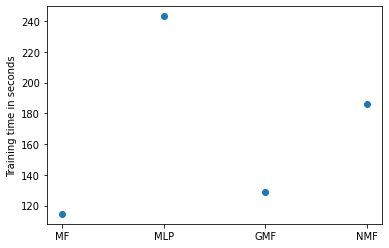

In [42]:
# plot a scatter plot of the training times for each model
# stop
plt.scatter(train_times_per_model3.keys(), train_times_per_model3.values())
# Add y axis label as "Training time in seconds"
plt.ylabel("Training time in seconds")

<br><br><br>
Metric Evaluation:

In [43]:
eval_results3= eval_results.copy()
eval_3={}
for top_k_name, top_k_value in top_k_values.items():
        for model_name, model in models.items():
            print(f"Model: {model_name} - Top {top_k_name}")
            mrr, ndcg, hit_rate = model_eval(model, test_ratings, test_neg_vector, top_k_value)
            res_metrics = {
                "mrr": mrr,
                "ndcg": ndcg,
                "hit_rate": hit_rate,
            }
            print(f"mrr: {mrr}, ndcg: {ndcg}, hit_rate: {hit_rate}")
            for metric_name in metric_names:
                eval_results3[model_name][top_k_name][metric_name] = res_metrics[metric_name]

Model: MF - Top 5_cutoff


100%|██████████| 6040/6040 [00:04<00:00, 1400.85it/s]


mrr: 0.26314293598233995, ndcg: 0.3120255827833759, hit_rate: 0.4607615894039735
Model: MLP - Top 5_cutoff


100%|██████████| 6040/6040 [00:05<00:00, 1027.71it/s]


mrr: 0.17930187637969094, ndcg: 0.21445420248002023, hit_rate: 0.3216887417218543
Model: GMF - Top 5_cutoff


100%|██████████| 6040/6040 [00:04<00:00, 1296.64it/s]


mrr: 0.25838024282560706, ndcg: 0.3078008219477454, hit_rate: 0.45827814569536424
Model: NMF - Top 5_cutoff


100%|██████████| 6040/6040 [00:06<00:00, 968.62it/s]


mrr: 0.2554139072847682, ndcg: 0.3041567626175048, hit_rate: 0.45264900662251656
Model: MF - Top 10_cutoff


100%|██████████| 6040/6040 [00:05<00:00, 1177.78it/s]


mrr: 0.28836670871439085, ndcg: 0.37297003702898407, hit_rate: 0.648841059602649
Model: MLP - Top 10_cutoff


100%|██████████| 6040/6040 [00:07<00:00, 860.71it/s]


mrr: 0.19816829601597813, ndcg: 0.2602648331155494, hit_rate: 0.46357615894039733
Model: GMF - Top 10_cutoff


100%|██████████| 6040/6040 [00:05<00:00, 1096.52it/s]


mrr: 0.28266989908546203, ndcg: 0.366239972391825, hit_rate: 0.6380794701986755
Model: NMF - Top 10_cutoff


100%|██████████| 6040/6040 [00:07<00:00, 854.73it/s]

mrr: 0.27930627825081467, ndcg: 0.3620999162353216, hit_rate: 0.631953642384106


In [ ]:
for metric_name in metric_names:
    for top_k_name, top_k_value in top_k_values.items():
        plt.title(f"{metric_name} for top {top_k_value}")
        for model_name, model in models.items():
            plt.bar(model_name, eval_results3[model_name][top_k_name][metric_name], label=f"{metric_name} {top_k_value} {model_name}")
        plt.legend()
        plt.show()

[0 1 2 3]


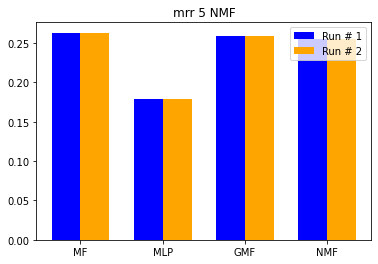

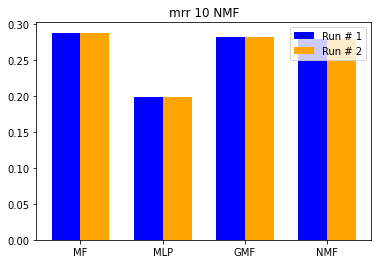

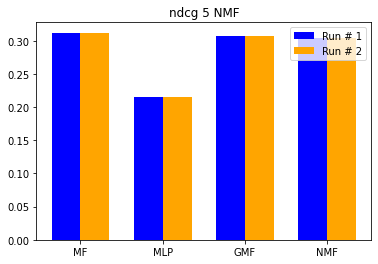

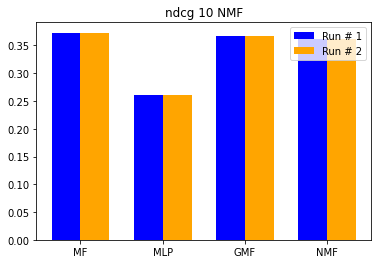

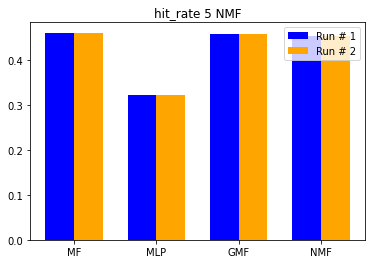

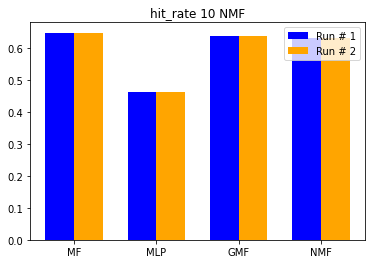

In [45]:
fig.set_size_inches(10,20)
bar_width= 0.35
run1= [None]* len(models.items())
run2= run1.copy()
index = np.arange(len(models))
print(index)
for metric_name in metric_names:
    for top_k_name, top_k_value in top_k_values.items():
        # plt.title(f"{metric_name} for top {top_k_value}")
        fig, ax = plt.subplots()
        i=0 
        for model_name, model in models.items():
            # plt.bar(model_name, eval_results3[model_name][top_k_name][metric_name], label=f"{metric_name} {top_k_value} {model_name}")
            run1[i], = ax.bar(index[i], eval_results[model_name][top_k_name][metric_name], bar_width, label="Run # 1", color="blue")
            run2[i], = ax.bar(index[i] + bar_width, eval_results3[model_name][top_k_name][metric_name], bar_width, label="Run # 2", color= "orange")
            i += 1
        ax.set_xticks(index + bar_width / 2)
  # ax[row].legend()
        ax.set_xticklabels(models.keys())
        ax.set_title(f"{metric_name} {top_k_value} {model_name}")
        # ax.set_label("rr","rrr")
        ax.legend([run1[0], run2[0]], ["Run # 1", "Run # 2"], loc= "upper right")
        plt.show()

### Conclusions
    

#### Effect of the activation and loss functions on the MLP model
On the the first run, the MLP model used Sigmoid as an activation funtion for all layers and the binary cross entropy for loss. On the seond run, we have used changed the model to use the ReLU activation function for the last layer, and mean squere error for calculating the loss. Detailed below are a few reults which have changed between the two runs.


##### Run time

Model| Sigmoid & BCE | ReLU & MSE | Ratio
---|---| ---|---|
MLP|378s | 261s|0.69 |

Second run of MLP training took 0.69 pf the first run duration. 


In [48]:
import pandas as pd
er= pd.DataFrame(eval_results)
er.to_csv('run1.csv')
er2= pd.DataFrame(eval_results3)
er2.to_csv('run2.csv')

#### 

<br><br>
<br><br>


Good Luck :)